- Run until the numba section then restart the runtime
- We need to restart since installing octis messes with the bertopic module

*Summary of Process*
- Make an initial model and bertopic df
- Infer the topic and summary through LLM, then come up with the topic name manually
- Manually infer the topic in words <=2, and outliers, save the updated bertopic df
- Fintune the topic cluster documents - meaning make an initial svm model since the svm model relatively has better transform predicting capability, or try cosine similarity, save the updated bertopic df
- Create a final supervised model based on the last updated bertopic df tags, save the model and the new bertopic df
- Make the master_topic_names sheet
- Finally use the summarizer again since the documents in the bertopic is updated and the topic arrangement might be now rearranged
- Create also a topic Description
- Save the summarized sub-topics and description
- Merged them and name the final merged with `bertopic_llm_Q1` df, this df will be used to pass to the Sentiment_Analysis_Steps notebook

In [ ]:
%%capture
!pip install octis
!pip install bertopic
!pip install transformers
!pip install spacy
!pip install spacy-transformers
!python -m spacy download en_core_web_trf
!pip install cohere

In [ ]:
import locale
print(locale.getpreferredencoding())

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip uninstall numba
!pip install -U numba

In [ ]:
import random
random.seed(3047)
# 3047

# Import Modules

In [ ]:
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.diversity_metrics import KLDivergence
from octis.evaluation_metrics.similarity_metrics import PairwiseJaccardSimilarity
from octis.evaluation_metrics.similarity_metrics import RBO

from typing import List

from transformers import pipeline

import pandas as pd
import numpy as np
from statistics import mean, median

# Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler

#Matplotlib
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import seaborn as sns
import torch

#Spacy
import spacy
nlp = spacy.load("en_core_web_trf")

#nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models

#BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.representation import PartOfSpeech
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import TextGeneration

#Plotly
import plotly.express as px
import plotly.graph_objects as go

import re

import cohere
co = cohere.Client('6A4zDKxyzr74fPKlMO7PJLvyhR8kOlB6s4vAcr9r')

# #pandasql
# from pandasql import sqldf
# mysql = lambda q: sqldf(q, globals())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/lo

### Input Question

In [ ]:
q = 'Q1'

In [ ]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/cleaned/'+q+'_cleaned.csv')
df

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model
0,Leadership,"Towards autonomous team, leadership should tru...","towards autonomous team, leadership should tru..."
1,Leadership,Good Leadership,good leadership.
2,Leadership,LT should be the first people in championing e...,lt should be the first people in championing e...
3,Leadership,I've been here for a year. There are things do...,i've been here for a year. there are things do...
4,Leadership,"People managers and leaders must talk about, r...",people manager_tags and leaders must talk abou...
...,...,...,...
557,Learning & Development,Having a good foundation of learning and devel...,having a good foundation of learning and devel...
558,Learning & Development,The company should be able to determine which ...,the company should be able to determine which ...
559,Learning & Development,More workshop that can help hone skills for cr...,more workshops that can help hone skills for c...
560,Learning & Development,There should be more avenues for us to explore...,there should be more avenues for us to explore...


In [ ]:
df.dropna(inplace=True)
df

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model
0,Leadership,"Towards autonomous team, leadership should tru...","towards autonomous team, leadership should tru..."
1,Leadership,Good Leadership,good leadership.
2,Leadership,LT should be the first people in championing e...,lt should be the first people in championing e...
3,Leadership,I've been here for a year. There are things do...,i've been here for a year. there are things do...
4,Leadership,"People managers and leaders must talk about, r...",people manager_tags and leaders must talk abou...
...,...,...,...
557,Learning & Development,Having a good foundation of learning and devel...,having a good foundation of learning and devel...
558,Learning & Development,The company should be able to determine which ...,the company should be able to determine which ...
559,Learning & Development,More workshop that can help hone skills for cr...,more workshops that can help hone skills for c...
560,Learning & Development,There should be more avenues for us to explore...,there should be more avenues for us to explore...


# PRE-PROCESSING FUNCTIONS

In [ ]:
def preprocess(text, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
  filtered_tokens_1 = []
  filtered_tokens_2 = []
  # remove stop words and lemmatize the text
  doc = nlp(text)
  for token in doc:
    # Remove stop words, punctiations, url's, emails, digits(pure digits)
    if token.is_stop or token.is_punct or token.like_url or token.like_email or token.is_digit:
        continue
    filtered_tokens_1.append(token.lemma_.lower()) #lemmatize then convert to lowercase

  # Retain the postags defined
  for text in filtered_tokens_1:
    doc = nlp(text)
    for token in doc:
      if token.pos_ in allowed_postags:
        filtered_tokens_2.append(token.lemma_)

  return filtered_tokens_2

# PRE-PROCESSING PIPELINE

In [ ]:
def pre_process_pipeline(texts):

  filtered_tokens = preprocess(texts)

  return filtered_tokens

In [ ]:
df['cleaned'] = df['for_topic_model'].apply(lambda x: pre_process_pipeline(x))
df['cleaned_joined'] = df['cleaned'].apply(lambda x: ' '.join(x))
df['length'] = df['for_topic_model'].apply(lambda x: len(' '.join(x.split('.')).split()))

In [ ]:
orig = df.copy()

In [ ]:
sep_12w = orig[orig['length'] <= 2]
sep_12w

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model,cleaned,cleaned_joined,length
1,Leadership,Good Leadership,good leadership.,"[good, leadership]",good leadership,2
37,Performance Management,Balanced KPIs,balanced kpis.,[balanced],balanced,2
57,Communication,Change Management,change management.,"[change, management]",change management,2
115,Collaboration,More partnerships,more partnerships.,[partnership],partnership,2
120,Collaboration,Synergies more,synergies more.,[synergy],synergy,2
153,Empowerment & Accountability,competitive salary,competitive salary.,"[competitive, salary]",competitive salary,2
173,Operating Efficiency,SYSTEM ENHANCEMENT,system enhancement.,"[system, enhancement]",system enhancement,2
211,Operating Efficiency,Clear roles,clear roles.,"[clear, role]",clear role,2
222,Operating Efficiency,Managing fraud,manage fraud.,"[manage, fraud]",manage fraud,2
234,Operating Efficiency,Error-free product,error-free product.,"[error, free, product]",error free product,2


In [ ]:
new_df = orig[(orig['length'] != 1) & (orig['length'] != 2)]
new_df

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model,cleaned,cleaned_joined,length
0,Leadership,"Towards autonomous team, leadership should tru...","towards autonomous team, leadership should tru...","[autonomous, team, leadership, trust, nurture,...",autonomous team leadership trust nurture self ...,22
2,Leadership,LT should be the first people in championing e...,lt should be the first people in championing e...,"[lt, people, champion, employee, recognition, ...",lt people champion employee recognition program,12
3,Leadership,I've been here for a year. There are things do...,i've been here for a year. there are things do...,"[year, thing, lot, thing, inefficient, choose,...",year thing lot thing inefficient choose leader...,45
4,Leadership,"People managers and leaders must talk about, r...",people manager_tags and leaders must talk abou...,"[people, manager_tag, leader, talk, model, val...",people manager_tag leader talk model value way...,36
5,Leadership,Leaders should be role models. They should be ...,leaders should be role models. they should be ...,"[leader, role, model, appoint, base, competenc...",leader role model appoint base competence know...,35
...,...,...,...,...,...,...
557,Learning & Development,Having a good foundation of learning and devel...,having a good foundation of learning and devel...,"[have, good, foundation, learn, development, e...",have good foundation learn development empower...,52
558,Learning & Development,The company should be able to determine which ...,the company should be able to determine which ...,"[company, able, determine, course, developer, ...",company able determine course developer attend...,18
559,Learning & Development,More workshop that can help hone skills for cr...,more workshops that can help hone skills for c...,"[workshop, help, skill, creative]",workshop help skill creative,9
560,Learning & Development,There should be more avenues for us to explore...,there should be more avenues for us to explore...,"[explore, cross, functional, role, year, rule,...",explore cross functional role year rule good w...,42


# TOPIC MODELING

In [ ]:
bertopic = new_df.copy()
bertopic

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model,cleaned,cleaned_joined,length
0,Leadership,"Towards autonomous team, leadership should tru...","towards autonomous team, leadership should tru...","[autonomous, team, leadership, trust, nurture,...",autonomous team leadership trust nurture self ...,22
2,Leadership,LT should be the first people in championing e...,lt should be the first people in championing e...,"[lt, people, champion, employee, recognition, ...",lt people champion employee recognition program,12
3,Leadership,I've been here for a year. There are things do...,i've been here for a year. there are things do...,"[year, thing, lot, thing, inefficient, choose,...",year thing lot thing inefficient choose leader...,45
4,Leadership,"People managers and leaders must talk about, r...",people manager_tags and leaders must talk abou...,"[people, manager_tag, leader, talk, model, val...",people manager_tag leader talk model value way...,36
5,Leadership,Leaders should be role models. They should be ...,leaders should be role models. they should be ...,"[leader, role, model, appoint, base, competenc...",leader role model appoint base competence know...,35
...,...,...,...,...,...,...
557,Learning & Development,Having a good foundation of learning and devel...,having a good foundation of learning and devel...,"[have, good, foundation, learn, development, e...",have good foundation learn development empower...,52
558,Learning & Development,The company should be able to determine which ...,the company should be able to determine which ...,"[company, able, determine, course, developer, ...",company able determine course developer attend...,18
559,Learning & Development,More workshop that can help hone skills for cr...,more workshops that can help hone skills for c...,"[workshop, help, skill, creative]",workshop help skill creative,9
560,Learning & Development,There should be more avenues for us to explore...,there should be more avenues for us to explore...,"[explore, cross, functional, role, year, rule,...",explore cross functional role year rule good w...,42


### Cross Validation

In [ ]:
docs_bert = bertopic['for_topic_model'].to_list()
n = len(docs_bert)
n

540

In [ ]:
# docs_bert_2 = []

# for i in docs_bert:
#   for r in list(filter(None, i.split('.'))):
#     docs_bert_2.append(r.lstrip())

In [ ]:
# docs_bert_2 = list(filter(None, docs_bert_2))
# len(docs_bert_2)

In [ ]:
def cv_tm(n_neighbors = [], min_dists = [], min_cluster_sizes= [], min_samples = []):

    no_of_topics_dic = []
    mean_topic_count_dic = []
    median_topic_count_dic = []
    outlier_perc_dic = []
    cv_coherence_score_dic = []
    n_neighbors_dic = []
    min_dists_dic = []
    min_cluster_sizes_dic = []
    min_samples_dic = []
    umass_coherence_score_dic = []
    cuci_coherence_score_dic = []
    cnpmi_coherence_score_dic = []
    topic_diversity_score_dic = []
    kldivergence_score_dic = []
    js_score_dic = []
    rbo_score_dic = []

    for n_neighbor in n_neighbors:
        for min_dist in min_dists:
            for min_cluster_size in min_cluster_sizes:
                for min_sample in min_samples:

                    embedding_model = SentenceTransformer('all-mpnet-base-v2')
                    umap_model = UMAP(n_neighbors=n_neighbor, n_components=3, min_dist=min_dist, random_state=42, metric='cosine')
                    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_sample,
                                            prediction_data=True, gen_min_span_tree=True)

                    # Create your representation model
                    pos = PartOfSpeech("en_core_web_sm", top_n_words=30)
                    mmr = MaximalMarginalRelevance(diversity=.4, top_n_words=8)
                    representation_model = [pos, mmr]

                    custom_stop_words = ['lack', 'culture', 'also', 'able', 'like', 'liked',
                                        'say', 'think', 'already', 'would', 'qa', 'us',
                                        'also', 'things', 'want', 'yes', 'no', 'thank',
                                        'you', 'thank you', 'given', 'feel', 'lot', 'many', 'due', 'sm']
                    stop_words = stopwords.words('english')
                    vectorizerr_model = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words+custom_stop_words)

                    cv_model = BERTopic(
                        embedding_model=embedding_model,
                        umap_model=umap_model,
                        hdbscan_model=hdbscan_model,
                        vectorizer_model=vectorizerr_model,
                        representation_model=representation_model,
                        top_n_words=8, # Just to show how many keywords, recommended upto only 10
                        language='english', # if most docs are english
                        calculate_probabilities=True, # To have all the probs of a topic in a document, not just the dominant
                        verbose=True,
                    )

                    cv_topics, cv_probs = cv_model.fit_transform(docs_bert)

                    # Make df
                    cv_bert_df = cv_model.get_topic_info()

                    # Get the number of topics inferred
                    no_of_topics = len(cv_bert_df[cv_bert_df['Topic'] != -1]['Topic'].unique())

                    # Get the mean topic count
                    mean_topic_count = mean(sorted(cv_bert_df[cv_bert_df['Topic'] != -1]['Count'].to_list()))

                    # Get the median topic count
                    median_topic_count = median(sorted(cv_bert_df[cv_bert_df['Topic'] != -1]['Count'].to_list()))

                    # Get the outlier percentage
                    outlier = list(cv_bert_df[cv_bert_df['Topic'] == -1]['Count'])

                    if not outlier: # If it doesn't have any outliers -- > 0 outliers
                        outlier_perc = round(len(outlier) / sum(list(cv_bert_df[cv_bert_df['Topic'] != -1]['Count']))*100, 2)
                    else: # If it has outliers
                        outlier_perc = round(outlier[0] / sum(list(cv_bert_df[cv_bert_df['Topic'] != -1]['Count']))*100, 2)

                    ########################### COHERENCE SCORE (c_v, u_mass, c_uci, c_npmi) ###################################
                    # Preprocess documents
                    cleaned_docs = cv_model._preprocess_text(docs_bert)

                    # Extract topics as word lists
                    topic_words = [[word for word, prob in cv_model.get_topic(topic)] for topic in set(cv_topics) if topic != -1]

                    # Extract vectorizer and tokenizer from BERTopic
                    vectorizer = cv_model.vectorizer_model
                    tokenizer = vectorizer.build_analyzer()

                    # Extract features for Topic Coherence evaluation
                    # words = vectorizer.get_feature_names()
                    tokens = [tokenizer(doc) for doc in cleaned_docs]

                    # Define coherence measure
                    cv_coherence = Coherence(texts = tokens, measure = 'c_v', topk = 8).score({'topics': topic_words})
                    umass_coherence = Coherence(texts = tokens, measure = 'u_mass', topk = 8).score({'topics': topic_words})
                    cuci_coherence = Coherence(texts = tokens, measure = 'c_uci', topk = 8).score({'topics': topic_words})
                    cnpmi_coherence = Coherence(texts = tokens, measure = 'c_npmi', topk = 8).score({'topics': topic_words})

                    ######################### TOPIC DIVERSITY (TD, KL_DIVERGENCE) ########################################
                    # Define topic diversity measure
                    diversity_metric = TopicDiversity(topk=8)  # You can set topk to the number of words you want to consider

                    # Compute the topic diversity
                    topic_diversity_score = diversity_metric.score({'topics': topic_words})

                    #### KL DIVERGENCE ####
                    # Define your vectorizer
                    vectorizer = cv_model.vectorizer_model

                    # Fit transform your documents
                    transformed_docs = vectorizer.fit_transform(docs_bert)

                    # Generate a topic-word matrix
                    topic_word_matrix = np.zeros((len(set(cv_topics)), len(vectorizer.get_feature_names())))

                    for topic in set(cv_topics):
                        if topic != -1:  # -1 represents outliers in BERTopic
                            topic_docs = transformed_docs[np.array(cv_topics) == topic]
                            topic_word_matrix[topic] = np.sum(topic_docs, axis=0)

                    # # Normalize rows to get probabilities instead of raw counts
                    # topic_word_matrix = topic_word_matrix / np.sum(topic_word_matrix, axis=1, keepdims=True)

                    # Define KL Divergence measure
                    kl_divergence = KLDivergence()

                    # Compute the KL Divergence
                    kldivergence_score = kl_divergence.score({'topic-word-matrix': topic_word_matrix})

                    ######################## SIMILARITY (JACCARD, RBO) ########################################
                    # Define topic diversity measure
                    similarity_metric = PairwiseJaccardSimilarity(topk=8)  # You can set topk to the number of words you want to consider

                    # Compute the topic diversity
                    js_score = similarity_metric.score({'topics': topic_words})

                    # Define topic diversity measure
                    rbo_metric = RBO(topk=8, weight=0.9)  # You can set topk to the number of words you want to consider

                    # Compute the topic diversity
                    rbo_score = rbo_metric.score({'topics': topic_words})



                    # Append values to lists
                    no_of_topics_dic.append(no_of_topics)
                    mean_topic_count_dic.append(mean_topic_count)
                    median_topic_count_dic.append(median_topic_count)
                    outlier_perc_dic.append(outlier_perc)
                    cv_coherence_score_dic.append(cv_coherence)
                    n_neighbors_dic.append(n_neighbor)
                    min_dists_dic.append(min_dist)
                    min_cluster_sizes_dic.append(min_cluster_size)
                    min_samples_dic.append(min_sample)
                    umass_coherence_score_dic.append(umass_coherence)
                    cuci_coherence_score_dic.append(cuci_coherence)
                    cnpmi_coherence_score_dic.append(cnpmi_coherence)
                    topic_diversity_score_dic.append(topic_diversity_score)
                    kldivergence_score_dic.append(kldivergence_score)
                    js_score_dic.append(js_score)
                    rbo_score_dic.append(rbo_score)

    bertopic_dic = {'topic_count': no_of_topics_dic,
                'mean_topic_count': mean_topic_count_dic,
                'median_topic_count': median_topic_count_dic,
                'outlier_perc': outlier_perc_dic,
                'cv_coherence_score_dic': cv_coherence_score_dic,
                'n_neighbors': n_neighbors_dic,
                'min_dists': min_dists_dic,
                'min_cluster_sizes': min_cluster_sizes_dic,
                'min_samples_dic': min_samples_dic,
                'umass_coherence_score_dic': umass_coherence_score_dic,
                'cuci_coherence_score_dic': cuci_coherence_score_dic,
                'cnpmi_coherence_score_dic': cnpmi_coherence_score_dic,
                'topic_diversity_score_dic': topic_diversity_score_dic,
                'kldivergence_score_dic': kldivergence_score_dic,
                'js_score_dic': js_score_dic,
                'rbo_score_dic': rbo_score_dic

                   }

    cv_bertopic = pd.DataFrame(bertopic_dic)

    return cv_bertopic

In [ ]:
cv_bertopic = cv_tm(n_neighbors= [5, 7, 10],
                    min_dists = np.arange(0.075,0.125,0.025), #0.075 to 0.1
                    min_cluster_sizes = np.arange(3,13), # 3 to 12
                    min_samples = [2, 3, 4, 5, 6]
                   )

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:09:30,193 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:09:31,904 - BERTopic - Reduced dimensionality
2023-06-05 02:09:32,038 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:09:47,507 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:09:49,815 - BERTopic - Reduced dimensionality
2023-06-05 02:09:49,910 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:10:02,355 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:10:04,019 - BERTopic - Reduced dimensionality
2023-06-05 02:10:04,088 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:10:14,397 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:10:16,138 - BERTopic - Reduced dimensionality
2023-06-05 02:10:16,196 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:10:24,665 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:10:26,557 - BERTopic - Reduced dimensionality
2023-06-05 02:10:26,592 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:10:31,567 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:10:33,300 - BERTopic - Reduced dimensionality
2023-06-05 02:10:33,391 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:10:45,742 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:10:47,451 - BERTopic - Reduced dimensionality
2023-06-05 02:10:47,529 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:10:58,881 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:11:00,725 - BERTopic - Reduced dimensionality
2023-06-05 02:11:00,793 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:11:10,348 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:11:12,251 - BERTopic - Reduced dimensionality
2023-06-05 02:11:12,303 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:11:20,850 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:11:22,618 - BERTopic - Reduced dimensionality
2023-06-05 02:11:22,651 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:11:27,411 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:11:29,964 - BERTopic - Reduced dimensionality
2023-06-05 02:11:30,038 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:11:39,896 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:11:41,674 - BERTopic - Reduced dimensionality
2023-06-05 02:11:41,741 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:11:51,730 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:11:53,403 - BERTopic - Reduced dimensionality
2023-06-05 02:11:53,463 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:12:03,822 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:12:05,497 - BERTopic - Reduced dimensionality
2023-06-05 02:12:05,549 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:12:13,497 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:12:15,414 - BERTopic - Reduced dimensionality
2023-06-05 02:12:15,445 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:12:20,972 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:12:22,674 - BERTopic - Reduced dimensionality
2023-06-05 02:12:22,738 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:12:33,533 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:12:35,210 - BERTopic - Reduced dimensionality
2023-06-05 02:12:35,269 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:12:44,209 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:12:46,117 - BERTopic - Reduced dimensionality
2023-06-05 02:12:46,183 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:12:54,967 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:12:56,711 - BERTopic - Reduced dimensionality
2023-06-05 02:12:56,759 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:13:05,397 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:13:07,693 - BERTopic - Reduced dimensionality
2023-06-05 02:13:07,724 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:13:12,492 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:13:14,280 - BERTopic - Reduced dimensionality
2023-06-05 02:13:14,331 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:13:22,626 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:13:24,311 - BERTopic - Reduced dimensionality
2023-06-05 02:13:24,357 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:13:33,075 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:13:34,872 - BERTopic - Reduced dimensionality
2023-06-05 02:13:34,931 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:13:42,342 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:13:44,013 - BERTopic - Reduced dimensionality
2023-06-05 02:13:44,045 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:13:49,239 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:13:51,683 - BERTopic - Reduced dimensionality
2023-06-05 02:13:51,716 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:13:56,459 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:13:58,152 - BERTopic - Reduced dimensionality
2023-06-05 02:13:58,201 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:14:06,413 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:14:08,109 - BERTopic - Reduced dimensionality
2023-06-05 02:14:08,154 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:14:15,835 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:14:17,758 - BERTopic - Reduced dimensionality
2023-06-05 02:14:17,791 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:14:23,249 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:14:24,936 - BERTopic - Reduced dimensionality
2023-06-05 02:14:24,968 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:14:29,768 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:14:32,164 - BERTopic - Reduced dimensionality
2023-06-05 02:14:32,200 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:14:37,570 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:14:39,237 - BERTopic - Reduced dimensionality
2023-06-05 02:14:39,287 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:14:46,776 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:14:48,571 - BERTopic - Reduced dimensionality
2023-06-05 02:14:48,607 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:14:53,639 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:14:55,337 - BERTopic - Reduced dimensionality
2023-06-05 02:14:55,369 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:15:00,132 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:15:01,833 - BERTopic - Reduced dimensionality
2023-06-05 02:15:01,877 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:15:06,789 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:15:09,137 - BERTopic - Reduced dimensionality
2023-06-05 02:15:09,167 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:15:14,028 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:15:15,777 - BERTopic - Reduced dimensionality
2023-06-05 02:15:15,820 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:15:23,655 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:15:25,348 - BERTopic - Reduced dimensionality
2023-06-05 02:15:25,382 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:15:30,264 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:15:31,984 - BERTopic - Reduced dimensionality
2023-06-05 02:15:32,017 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:15:36,904 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:15:38,720 - BERTopic - Reduced dimensionality
2023-06-05 02:15:38,754 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:15:43,515 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:15:46,051 - BERTopic - Reduced dimensionality
2023-06-05 02:15:46,087 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:15:51,489 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:15:53,504 - BERTopic - Reduced dimensionality
2023-06-05 02:15:53,551 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:16:00,854 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:16:02,522 - BERTopic - Reduced dimensionality
2023-06-05 02:16:02,555 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:16:07,918 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:16:09,693 - BERTopic - Reduced dimensionality
2023-06-05 02:16:09,727 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:16:14,392 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:16:16,055 - BERTopic - Reduced dimensionality
2023-06-05 02:16:16,085 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:16:20,991 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:16:23,549 - BERTopic - Reduced dimensionality
2023-06-05 02:16:23,579 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:16:28,309 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:16:29,989 - BERTopic - Reduced dimensionality
2023-06-05 02:16:30,032 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:16:37,667 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:16:39,514 - BERTopic - Reduced dimensionality
2023-06-05 02:16:39,547 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:16:44,240 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:16:45,903 - BERTopic - Reduced dimensionality
2023-06-05 02:16:45,936 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:16:50,656 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:16:52,547 - BERTopic - Reduced dimensionality
2023-06-05 02:16:52,579 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:16:57,356 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:16:59,693 - BERTopic - Reduced dimensionality
2023-06-05 02:16:59,722 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:17:04,318 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:17:06,160 - BERTopic - Reduced dimensionality
2023-06-05 02:17:06,290 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:17:19,652 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:17:21,427 - BERTopic - Reduced dimensionality
2023-06-05 02:17:21,517 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:17:31,913 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:17:33,610 - BERTopic - Reduced dimensionality
2023-06-05 02:17:33,675 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:17:43,852 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:17:46,154 - BERTopic - Reduced dimensionality
2023-06-05 02:17:46,208 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:17:55,084 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:17:56,808 - BERTopic - Reduced dimensionality
2023-06-05 02:17:56,842 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:18:01,599 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:18:03,310 - BERTopic - Reduced dimensionality
2023-06-05 02:18:03,400 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:18:15,128 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:18:16,803 - BERTopic - Reduced dimensionality
2023-06-05 02:18:16,876 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:18:27,831 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:18:29,551 - BERTopic - Reduced dimensionality
2023-06-05 02:18:29,617 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:18:39,424 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:18:41,284 - BERTopic - Reduced dimensionality
2023-06-05 02:18:41,339 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:18:49,877 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:18:51,511 - BERTopic - Reduced dimensionality
2023-06-05 02:18:51,541 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:18:57,516 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:18:59,197 - BERTopic - Reduced dimensionality
2023-06-05 02:18:59,272 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:19:08,920 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:19:10,674 - BERTopic - Reduced dimensionality
2023-06-05 02:19:10,749 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:19:20,260 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:19:22,615 - BERTopic - Reduced dimensionality
2023-06-05 02:19:22,698 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:19:32,404 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:19:34,096 - BERTopic - Reduced dimensionality
2023-06-05 02:19:34,152 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:19:43,043 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:19:44,723 - BERTopic - Reduced dimensionality
2023-06-05 02:19:44,756 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:19:49,415 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:19:51,087 - BERTopic - Reduced dimensionality
2023-06-05 02:19:51,152 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:20:00,833 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:20:02,508 - BERTopic - Reduced dimensionality
2023-06-05 02:20:02,566 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:20:11,603 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:20:14,209 - BERTopic - Reduced dimensionality
2023-06-05 02:20:14,277 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:20:22,557 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:20:24,240 - BERTopic - Reduced dimensionality
2023-06-05 02:20:24,296 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:20:32,456 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:20:34,176 - BERTopic - Reduced dimensionality
2023-06-05 02:20:34,206 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:20:38,991 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:20:40,729 - BERTopic - Reduced dimensionality
2023-06-05 02:20:40,780 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:20:49,668 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:20:51,444 - BERTopic - Reduced dimensionality
2023-06-05 02:20:51,490 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:21:00,077 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:21:02,633 - BERTopic - Reduced dimensionality
2023-06-05 02:21:02,667 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:21:07,402 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:21:09,142 - BERTopic - Reduced dimensionality
2023-06-05 02:21:09,176 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:21:14,501 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:21:16,450 - BERTopic - Reduced dimensionality
2023-06-05 02:21:16,482 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:21:21,253 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:21:22,955 - BERTopic - Reduced dimensionality
2023-06-05 02:21:23,000 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:21:31,255 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:21:33,039 - BERTopic - Reduced dimensionality
2023-06-05 02:21:33,072 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:21:37,695 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:21:40,036 - BERTopic - Reduced dimensionality
2023-06-05 02:21:40,070 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:21:45,360 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:21:47,209 - BERTopic - Reduced dimensionality
2023-06-05 02:21:47,240 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:21:51,979 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:21:53,689 - BERTopic - Reduced dimensionality
2023-06-05 02:21:53,723 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:21:58,495 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:22:00,392 - BERTopic - Reduced dimensionality
2023-06-05 02:22:00,441 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:22:08,403 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:22:10,131 - BERTopic - Reduced dimensionality
2023-06-05 02:22:10,163 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:22:15,247 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:22:17,798 - BERTopic - Reduced dimensionality
2023-06-05 02:22:17,833 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:22:22,578 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:22:24,322 - BERTopic - Reduced dimensionality
2023-06-05 02:22:24,354 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:22:29,236 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:22:31,257 - BERTopic - Reduced dimensionality
2023-06-05 02:22:31,296 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:22:36,312 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:22:38,081 - BERTopic - Reduced dimensionality
2023-06-05 02:22:38,128 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:22:46,748 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:22:48,691 - BERTopic - Reduced dimensionality
2023-06-05 02:22:48,724 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:22:53,501 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:22:55,245 - BERTopic - Reduced dimensionality
2023-06-05 02:22:55,283 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:23:04,075 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:23:05,801 - BERTopic - Reduced dimensionality
2023-06-05 02:23:05,834 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:23:10,547 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:23:12,261 - BERTopic - Reduced dimensionality
2023-06-05 02:23:12,293 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:23:17,391 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:23:19,197 - BERTopic - Reduced dimensionality
2023-06-05 02:23:19,239 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:23:26,596 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:23:28,300 - BERTopic - Reduced dimensionality
2023-06-05 02:23:28,341 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:23:36,208 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:23:37,947 - BERTopic - Reduced dimensionality
2023-06-05 02:23:37,982 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:23:45,228 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:23:47,146 - BERTopic - Reduced dimensionality
2023-06-05 02:23:47,182 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:23:52,087 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:23:53,786 - BERTopic - Reduced dimensionality
2023-06-05 02:23:53,816 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:23:58,602 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:24:00,435 - BERTopic - Reduced dimensionality
2023-06-05 02:24:00,478 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:24:08,350 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:24:10,125 - BERTopic - Reduced dimensionality
2023-06-05 02:24:10,159 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:24:15,007 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:24:16,861 - BERTopic - Reduced dimensionality
2023-06-05 02:24:16,899 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:24:24,896 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:24:26,619 - BERTopic - Reduced dimensionality
2023-06-05 02:24:26,649 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:24:31,372 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:24:33,239 - BERTopic - Reduced dimensionality
2023-06-05 02:24:33,269 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:24:38,209 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:24:40,074 - BERTopic - Reduced dimensionality
2023-06-05 02:24:40,213 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:24:55,595 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:24:57,492 - BERTopic - Reduced dimensionality
2023-06-05 02:24:57,578 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:25:09,468 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:25:11,359 - BERTopic - Reduced dimensionality
2023-06-05 02:25:11,441 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:25:21,022 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:25:23,043 - BERTopic - Reduced dimensionality
2023-06-05 02:25:23,101 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:25:31,271 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:25:33,138 - BERTopic - Reduced dimensionality
2023-06-05 02:25:33,188 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:25:42,065 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:25:43,894 - BERTopic - Reduced dimensionality
2023-06-05 02:25:44,006 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:25:55,673 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:25:57,533 - BERTopic - Reduced dimensionality
2023-06-05 02:25:57,605 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:26:08,999 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:26:11,095 - BERTopic - Reduced dimensionality
2023-06-05 02:26:11,157 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:26:20,477 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:26:22,476 - BERTopic - Reduced dimensionality
2023-06-05 02:26:22,532 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:26:31,173 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:26:33,055 - BERTopic - Reduced dimensionality
2023-06-05 02:26:33,101 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:26:40,919 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:26:42,886 - BERTopic - Reduced dimensionality
2023-06-05 02:26:42,965 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:26:53,579 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:26:56,326 - BERTopic - Reduced dimensionality
2023-06-05 02:26:56,392 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:27:05,630 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:27:07,508 - BERTopic - Reduced dimensionality
2023-06-05 02:27:07,573 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:27:17,459 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:27:19,289 - BERTopic - Reduced dimensionality
2023-06-05 02:27:19,337 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:27:27,686 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:27:29,685 - BERTopic - Reduced dimensionality
2023-06-05 02:27:29,726 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:27:36,952 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:27:38,811 - BERTopic - Reduced dimensionality
2023-06-05 02:27:38,873 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:27:48,468 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:27:50,968 - BERTopic - Reduced dimensionality
2023-06-05 02:27:51,016 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:27:59,265 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:28:01,223 - BERTopic - Reduced dimensionality
2023-06-05 02:28:01,273 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:28:09,324 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:28:11,230 - BERTopic - Reduced dimensionality
2023-06-05 02:28:11,274 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:28:19,401 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:28:21,239 - BERTopic - Reduced dimensionality
2023-06-05 02:28:21,279 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:28:28,895 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:28:30,836 - BERTopic - Reduced dimensionality
2023-06-05 02:28:30,879 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:28:39,383 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:28:41,295 - BERTopic - Reduced dimensionality
2023-06-05 02:28:41,342 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:28:48,936 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:28:50,746 - BERTopic - Reduced dimensionality
2023-06-05 02:28:50,787 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:28:58,448 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:29:00,514 - BERTopic - Reduced dimensionality
2023-06-05 02:29:00,568 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:29:07,887 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:29:09,707 - BERTopic - Reduced dimensionality
2023-06-05 02:29:09,758 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:29:17,821 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:29:19,684 - BERTopic - Reduced dimensionality
2023-06-05 02:29:19,729 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:29:27,833 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:29:29,814 - BERTopic - Reduced dimensionality
2023-06-05 02:29:29,856 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:29:36,975 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:29:38,794 - BERTopic - Reduced dimensionality
2023-06-05 02:29:38,834 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:29:46,284 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:29:48,252 - BERTopic - Reduced dimensionality
2023-06-05 02:29:48,289 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:29:55,057 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:29:56,901 - BERTopic - Reduced dimensionality
2023-06-05 02:29:56,936 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:30:03,781 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:30:05,675 - BERTopic - Reduced dimensionality
2023-06-05 02:30:05,711 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:30:10,857 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:30:12,712 - BERTopic - Reduced dimensionality
2023-06-05 02:30:12,750 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:30:20,525 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:30:22,405 - BERTopic - Reduced dimensionality
2023-06-05 02:30:22,445 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:30:29,362 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:30:31,465 - BERTopic - Reduced dimensionality
2023-06-05 02:30:31,504 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:30:38,423 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:30:40,317 - BERTopic - Reduced dimensionality
2023-06-05 02:30:40,353 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:30:47,189 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:30:49,929 - BERTopic - Reduced dimensionality
2023-06-05 02:30:49,959 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:30:54,411 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:30:56,218 - BERTopic - Reduced dimensionality
2023-06-05 02:30:56,259 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:31:02,932 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:31:04,907 - BERTopic - Reduced dimensionality
2023-06-05 02:31:04,946 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:31:11,400 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:31:13,307 - BERTopic - Reduced dimensionality
2023-06-05 02:31:13,344 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:31:20,174 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:31:21,972 - BERTopic - Reduced dimensionality
2023-06-05 02:31:22,011 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:31:28,381 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:31:30,959 - BERTopic - Reduced dimensionality
2023-06-05 02:31:30,996 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:31:36,262 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:31:38,044 - BERTopic - Reduced dimensionality
2023-06-05 02:31:38,080 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:31:44,512 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:31:46,373 - BERTopic - Reduced dimensionality
2023-06-05 02:31:46,415 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:31:53,248 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:31:55,067 - BERTopic - Reduced dimensionality
2023-06-05 02:31:55,102 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:32:01,419 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:32:03,343 - BERTopic - Reduced dimensionality
2023-06-05 02:32:03,380 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:32:09,984 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:32:11,772 - BERTopic - Reduced dimensionality
2023-06-05 02:32:11,804 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:32:16,903 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:32:18,865 - BERTopic - Reduced dimensionality
2023-06-05 02:32:18,907 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:32:25,363 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:32:27,167 - BERTopic - Reduced dimensionality
2023-06-05 02:32:27,202 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:32:34,152 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:32:36,131 - BERTopic - Reduced dimensionality
2023-06-05 02:32:36,168 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:32:42,394 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:32:44,211 - BERTopic - Reduced dimensionality
2023-06-05 02:32:44,242 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:32:49,217 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:32:51,185 - BERTopic - Reduced dimensionality
2023-06-05 02:32:51,322 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:33:05,871 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:33:07,780 - BERTopic - Reduced dimensionality
2023-06-05 02:33:07,865 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:33:18,517 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:33:20,545 - BERTopic - Reduced dimensionality
2023-06-05 02:33:20,608 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:33:29,430 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:33:31,241 - BERTopic - Reduced dimensionality
2023-06-05 02:33:31,290 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:33:40,103 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:33:42,541 - BERTopic - Reduced dimensionality
2023-06-05 02:33:42,573 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:33:47,091 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:33:48,957 - BERTopic - Reduced dimensionality
2023-06-05 02:33:49,049 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:34:00,435 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:34:02,268 - BERTopic - Reduced dimensionality
2023-06-05 02:34:02,336 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:34:12,540 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:34:14,353 - BERTopic - Reduced dimensionality
2023-06-05 02:34:14,412 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:34:23,140 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:34:25,001 - BERTopic - Reduced dimensionality
2023-06-05 02:34:25,050 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:34:32,712 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:34:35,346 - BERTopic - Reduced dimensionality
2023-06-05 02:34:35,379 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:34:40,330 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:34:42,202 - BERTopic - Reduced dimensionality
2023-06-05 02:34:42,272 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:34:52,790 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:34:54,962 - BERTopic - Reduced dimensionality
2023-06-05 02:34:55,023 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:35:03,905 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:35:05,883 - BERTopic - Reduced dimensionality
2023-06-05 02:35:05,950 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:35:15,303 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:35:17,196 - BERTopic - Reduced dimensionality
2023-06-05 02:35:17,244 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:35:25,739 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:35:28,421 - BERTopic - Reduced dimensionality
2023-06-05 02:35:28,455 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:35:33,017 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:35:34,877 - BERTopic - Reduced dimensionality
2023-06-05 02:35:34,931 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:35:44,613 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:35:46,466 - BERTopic - Reduced dimensionality
2023-06-05 02:35:46,519 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:35:55,482 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:35:57,470 - BERTopic - Reduced dimensionality
2023-06-05 02:35:57,527 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:36:05,477 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:36:07,339 - BERTopic - Reduced dimensionality
2023-06-05 02:36:07,384 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:36:15,412 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:36:17,260 - BERTopic - Reduced dimensionality
2023-06-05 02:36:17,290 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:36:22,508 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:36:24,400 - BERTopic - Reduced dimensionality
2023-06-05 02:36:24,451 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:36:33,259 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:36:35,115 - BERTopic - Reduced dimensionality
2023-06-05 02:36:35,162 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:36:43,501 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:36:45,458 - BERTopic - Reduced dimensionality
2023-06-05 02:36:45,501 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:36:52,616 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:36:54,481 - BERTopic - Reduced dimensionality
2023-06-05 02:36:54,523 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:37:01,524 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:37:03,443 - BERTopic - Reduced dimensionality
2023-06-05 02:37:03,473 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:37:08,799 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:37:10,718 - BERTopic - Reduced dimensionality
2023-06-05 02:37:10,767 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:37:19,010 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:37:20,880 - BERTopic - Reduced dimensionality
2023-06-05 02:37:20,920 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:37:28,149 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:37:30,144 - BERTopic - Reduced dimensionality
2023-06-05 02:37:30,195 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:37:37,000 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:37:38,803 - BERTopic - Reduced dimensionality
2023-06-05 02:37:38,840 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:37:45,974 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:37:47,865 - BERTopic - Reduced dimensionality
2023-06-05 02:37:47,897 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:37:53,150 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:37:54,987 - BERTopic - Reduced dimensionality
2023-06-05 02:37:55,034 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:38:03,052 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:38:04,878 - BERTopic - Reduced dimensionality
2023-06-05 02:38:04,919 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:38:11,563 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:38:13,438 - BERTopic - Reduced dimensionality
2023-06-05 02:38:13,480 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:38:20,542 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:38:22,392 - BERTopic - Reduced dimensionality
2023-06-05 02:38:22,428 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:38:28,970 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:38:30,939 - BERTopic - Reduced dimensionality
2023-06-05 02:38:30,970 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:38:36,326 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:38:38,108 - BERTopic - Reduced dimensionality
2023-06-05 02:38:38,148 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:38:44,910 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:38:47,004 - BERTopic - Reduced dimensionality
2023-06-05 02:38:47,048 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:38:53,574 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:38:55,425 - BERTopic - Reduced dimensionality
2023-06-05 02:38:55,466 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:39:02,645 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:39:04,575 - BERTopic - Reduced dimensionality
2023-06-05 02:39:04,610 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:39:11,147 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:39:12,962 - BERTopic - Reduced dimensionality
2023-06-05 02:39:12,992 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:39:19,507 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:39:21,372 - BERTopic - Reduced dimensionality
2023-06-05 02:39:21,411 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:39:28,336 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:39:30,254 - BERTopic - Reduced dimensionality
2023-06-05 02:39:30,293 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:39:37,205 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:39:39,115 - BERTopic - Reduced dimensionality
2023-06-05 02:39:39,154 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:39:45,912 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:39:47,916 - BERTopic - Reduced dimensionality
2023-06-05 02:39:47,950 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:39:52,667 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:39:54,475 - BERTopic - Reduced dimensionality
2023-06-05 02:39:54,506 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:39:59,082 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:40:01,751 - BERTopic - Reduced dimensionality
2023-06-05 02:40:01,789 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:40:07,302 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:40:09,166 - BERTopic - Reduced dimensionality
2023-06-05 02:40:09,206 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:40:15,385 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:40:17,418 - BERTopic - Reduced dimensionality
2023-06-05 02:40:17,461 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:40:24,464 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:40:26,354 - BERTopic - Reduced dimensionality
2023-06-05 02:40:26,384 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:40:31,021 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:40:33,123 - BERTopic - Reduced dimensionality
2023-06-05 02:40:33,157 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:40:38,067 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:40:40,748 - BERTopic - Reduced dimensionality
2023-06-05 02:40:40,877 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:40:54,889 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:40:57,004 - BERTopic - Reduced dimensionality
2023-06-05 02:40:57,086 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:41:08,275 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:41:10,365 - BERTopic - Reduced dimensionality
2023-06-05 02:41:10,432 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:41:19,392 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:41:21,591 - BERTopic - Reduced dimensionality
2023-06-05 02:41:21,647 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:41:29,770 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:41:32,525 - BERTopic - Reduced dimensionality
2023-06-05 02:41:32,556 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:41:38,055 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:41:40,229 - BERTopic - Reduced dimensionality
2023-06-05 02:41:40,319 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:41:51,529 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:41:53,741 - BERTopic - Reduced dimensionality
2023-06-05 02:41:53,816 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:42:03,352 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:42:05,366 - BERTopic - Reduced dimensionality
2023-06-05 02:42:05,421 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:42:14,162 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:42:16,172 - BERTopic - Reduced dimensionality
2023-06-05 02:42:16,222 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:42:25,465 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:42:28,260 - BERTopic - Reduced dimensionality
2023-06-05 02:42:28,292 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:42:33,166 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:42:35,168 - BERTopic - Reduced dimensionality
2023-06-05 02:42:35,229 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:42:45,197 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:42:47,194 - BERTopic - Reduced dimensionality
2023-06-05 02:42:47,249 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:42:56,133 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:42:58,249 - BERTopic - Reduced dimensionality
2023-06-05 02:42:58,301 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:43:06,508 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:43:08,590 - BERTopic - Reduced dimensionality
2023-06-05 02:43:08,626 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:43:14,008 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:43:16,812 - BERTopic - Reduced dimensionality
2023-06-05 02:43:16,845 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:43:21,703 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:43:23,789 - BERTopic - Reduced dimensionality
2023-06-05 02:43:23,840 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:43:32,365 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:43:34,445 - BERTopic - Reduced dimensionality
2023-06-05 02:43:34,495 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:43:42,869 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:43:45,031 - BERTopic - Reduced dimensionality
2023-06-05 02:43:45,078 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:43:52,621 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:43:54,702 - BERTopic - Reduced dimensionality
2023-06-05 02:43:54,737 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:44:00,022 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:44:02,807 - BERTopic - Reduced dimensionality
2023-06-05 02:44:02,840 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:44:07,764 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:44:09,807 - BERTopic - Reduced dimensionality
2023-06-05 02:44:09,856 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:44:17,515 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:44:19,554 - BERTopic - Reduced dimensionality
2023-06-05 02:44:19,593 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:44:26,484 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:44:28,676 - BERTopic - Reduced dimensionality
2023-06-05 02:44:28,714 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:44:33,785 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:44:35,873 - BERTopic - Reduced dimensionality
2023-06-05 02:44:35,909 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:44:40,817 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:44:43,901 - BERTopic - Reduced dimensionality
2023-06-05 02:44:43,938 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:44:49,054 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:44:51,115 - BERTopic - Reduced dimensionality
2023-06-05 02:44:51,157 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:44:58,384 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:45:00,627 - BERTopic - Reduced dimensionality
2023-06-05 02:45:00,672 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:45:07,733 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:45:09,787 - BERTopic - Reduced dimensionality
2023-06-05 02:45:09,819 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:45:15,195 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:45:17,485 - BERTopic - Reduced dimensionality
2023-06-05 02:45:17,515 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:45:22,369 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:45:24,348 - BERTopic - Reduced dimensionality
2023-06-05 02:45:24,381 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:45:30,193 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:45:32,346 - BERTopic - Reduced dimensionality
2023-06-05 02:45:32,392 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:45:39,495 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:45:41,497 - BERTopic - Reduced dimensionality
2023-06-05 02:45:41,539 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:45:49,693 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:45:51,681 - BERTopic - Reduced dimensionality
2023-06-05 02:45:51,723 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:45:58,629 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:46:00,834 - BERTopic - Reduced dimensionality
2023-06-05 02:46:00,875 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:46:05,886 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:46:07,846 - BERTopic - Reduced dimensionality
2023-06-05 02:46:07,878 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:46:13,410 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:46:15,662 - BERTopic - Reduced dimensionality
2023-06-05 02:46:15,705 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:46:22,936 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:46:24,901 - BERTopic - Reduced dimensionality
2023-06-05 02:46:24,947 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:46:31,623 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:46:33,800 - BERTopic - Reduced dimensionality
2023-06-05 02:46:33,848 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:46:40,605 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:46:42,634 - BERTopic - Reduced dimensionality
2023-06-05 02:46:42,671 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:46:48,183 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:46:50,341 - BERTopic - Reduced dimensionality
2023-06-05 02:46:50,373 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:46:55,140 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:46:57,857 - BERTopic - Reduced dimensionality
2023-06-05 02:46:57,898 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:47:05,089 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:47:07,137 - BERTopic - Reduced dimensionality
2023-06-05 02:47:07,176 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:47:13,999 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:47:16,041 - BERTopic - Reduced dimensionality
2023-06-05 02:47:16,083 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:47:22,798 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:47:24,778 - BERTopic - Reduced dimensionality
2023-06-05 02:47:24,812 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:47:29,639 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:47:31,711 - BERTopic - Reduced dimensionality
2023-06-05 02:47:31,745 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:47:37,140 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:47:39,865 - BERTopic - Reduced dimensionality
2023-06-05 02:47:39,904 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:47:46,786 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:47:48,974 - BERTopic - Reduced dimensionality
2023-06-05 02:47:49,022 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:47:55,829 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:47:57,837 - BERTopic - Reduced dimensionality
2023-06-05 02:47:57,869 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:48:02,507 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:48:04,689 - BERTopic - Reduced dimensionality
2023-06-05 02:48:04,722 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:48:09,821 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:48:11,800 - BERTopic - Reduced dimensionality
2023-06-05 02:48:11,832 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:48:16,377 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:48:19,135 - BERTopic - Reduced dimensionality
2023-06-05 02:48:19,264 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:48:32,058 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:48:34,111 - BERTopic - Reduced dimensionality
2023-06-05 02:48:34,191 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:48:44,492 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:48:46,464 - BERTopic - Reduced dimensionality
2023-06-05 02:48:46,518 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:48:55,911 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:48:57,906 - BERTopic - Reduced dimensionality
2023-06-05 02:48:57,959 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:49:05,484 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:49:07,703 - BERTopic - Reduced dimensionality
2023-06-05 02:49:07,740 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:49:13,522 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:49:15,594 - BERTopic - Reduced dimensionality
2023-06-05 02:49:15,690 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:49:28,081 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:49:30,063 - BERTopic - Reduced dimensionality
2023-06-05 02:49:30,131 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:49:40,940 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:49:42,991 - BERTopic - Reduced dimensionality
2023-06-05 02:49:43,052 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:49:51,259 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:49:53,429 - BERTopic - Reduced dimensionality
2023-06-05 02:49:53,481 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:50:01,334 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:50:03,340 - BERTopic - Reduced dimensionality
2023-06-05 02:50:03,373 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:50:09,024 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:50:11,224 - BERTopic - Reduced dimensionality
2023-06-05 02:50:11,296 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:50:20,111 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:50:22,088 - BERTopic - Reduced dimensionality
2023-06-05 02:50:22,145 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:50:30,952 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:50:33,086 - BERTopic - Reduced dimensionality
2023-06-05 02:50:33,137 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:50:41,973 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:50:44,178 - BERTopic - Reduced dimensionality
2023-06-05 02:50:44,212 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:50:49,126 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:50:51,259 - BERTopic - Reduced dimensionality
2023-06-05 02:50:51,291 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:50:57,346 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:50:59,531 - BERTopic - Reduced dimensionality
2023-06-05 02:50:59,585 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:51:07,938 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:51:10,047 - BERTopic - Reduced dimensionality
2023-06-05 02:51:10,103 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:51:18,265 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:51:20,252 - BERTopic - Reduced dimensionality
2023-06-05 02:51:20,287 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:51:24,821 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:51:26,935 - BERTopic - Reduced dimensionality
2023-06-05 02:51:26,974 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:51:32,112 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:51:34,157 - BERTopic - Reduced dimensionality
2023-06-05 02:51:34,192 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:51:39,769 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:51:41,801 - BERTopic - Reduced dimensionality
2023-06-05 02:51:41,849 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:51:49,495 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:51:51,455 - BERTopic - Reduced dimensionality
2023-06-05 02:51:51,499 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:51:59,055 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:52:01,228 - BERTopic - Reduced dimensionality
2023-06-05 02:52:01,277 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:52:08,009 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:52:09,982 - BERTopic - Reduced dimensionality
2023-06-05 02:52:10,013 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:52:16,066 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:52:18,150 - BERTopic - Reduced dimensionality
2023-06-05 02:52:18,181 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:52:23,014 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:52:25,641 - BERTopic - Reduced dimensionality
2023-06-05 02:52:25,688 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:52:33,535 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:52:35,532 - BERTopic - Reduced dimensionality
2023-06-05 02:52:35,574 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:52:42,463 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:52:44,543 - BERTopic - Reduced dimensionality
2023-06-05 02:52:44,576 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:52:49,481 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:52:51,470 - BERTopic - Reduced dimensionality
2023-06-05 02:52:51,500 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:52:56,487 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:52:58,530 - BERTopic - Reduced dimensionality
2023-06-05 02:52:58,566 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:53:03,808 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:53:06,477 - BERTopic - Reduced dimensionality
2023-06-05 02:53:06,519 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:53:13,618 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:53:15,725 - BERTopic - Reduced dimensionality
2023-06-05 02:53:15,769 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:53:22,605 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:53:24,571 - BERTopic - Reduced dimensionality
2023-06-05 02:53:24,603 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:53:29,084 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:53:31,241 - BERTopic - Reduced dimensionality
2023-06-05 02:53:31,275 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:53:36,333 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:53:38,300 - BERTopic - Reduced dimensionality
2023-06-05 02:53:38,332 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:53:43,127 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:53:45,876 - BERTopic - Reduced dimensionality
2023-06-05 02:53:45,920 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:53:53,131 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:53:55,088 - BERTopic - Reduced dimensionality
2023-06-05 02:53:55,121 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:53:59,808 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:54:01,913 - BERTopic - Reduced dimensionality
2023-06-05 02:54:01,948 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:54:06,917 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:54:08,867 - BERTopic - Reduced dimensionality
2023-06-05 02:54:08,899 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:54:13,744 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:54:15,773 - BERTopic - Reduced dimensionality
2023-06-05 02:54:15,805 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:54:20,941 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:54:22,880 - BERTopic - Reduced dimensionality
2023-06-05 02:54:22,919 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:54:30,350 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:54:32,521 - BERTopic - Reduced dimensionality
2023-06-05 02:54:32,553 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:54:37,386 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:54:39,392 - BERTopic - Reduced dimensionality
2023-06-05 02:54:39,421 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:54:43,917 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:54:45,939 - BERTopic - Reduced dimensionality
2023-06-05 02:54:45,973 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:54:51,298 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:54:53,290 - BERTopic - Reduced dimensionality
2023-06-05 02:54:53,324 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:54:58,206 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:55:00,179 - BERTopic - Reduced dimensionality
2023-06-05 02:55:00,224 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:55:08,113 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:55:10,115 - BERTopic - Reduced dimensionality
2023-06-05 02:55:10,146 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:55:14,679 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:55:16,719 - BERTopic - Reduced dimensionality
2023-06-05 02:55:16,751 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:55:21,524 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:55:23,477 - BERTopic - Reduced dimensionality
2023-06-05 02:55:23,508 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 02:55:28,285 - BERTopic - Transformed documents to Embeddings
2023-06-05 02:55:30,229 - BERTopic - Reduced dimensionality
2023-06-05 02:55:30,260 - BERTopic - Clustered reduced embeddings


In [ ]:
cv_bertopic.to_csv(r'/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/cross_validation/cv_bertopic_'+q+'.csv', index=False)

In [ ]:
cv_bertopic

,topic_count,mean_topic_count,median_topic_count,outlier_perc,cv_coherence_score_dic,n_neighbors,min_dists,min_cluster_sizes,min_samples_dic,umass_coherence_score_dic,cuci_coherence_score_dic,cnpmi_coherence_score_dic,topic_diversity_score_dic,kldivergence_score_dic,js_score_dic,rbo_score_dic
0,71,6.295775,6.0,20.81,0.356477,5,0.075,3,2,-13.763756,-10.037801,-0.281985,0.829225,2352.636028,0.004545,0.005514
1,50,8.500000,7.0,27.06,0.336180,5,0.075,3,3,-15.306668,-10.927572,-0.333230,0.875000,2989.416163,0.005224,0.007127
2,37,11.216216,7.0,30.12,0.348714,5,0.075,3,4,-15.485311,-10.748297,-0.323655,0.895270,4580.350131,0.005077,0.008745
3,30,13.333333,8.5,35.00,0.339896,5,0.075,3,5,-14.997217,-10.463936,-0.308290,0.875000,5717.626750,0.008495,0.012475
4,3,172.333333,45.0,4.45,0.313808,5,0.075,3,6,-12.215106,-7.780599,-0.229211,0.833333,69154.516717,0.099145,0.167308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,13,32.692308,27.0,27.06,0.333389,10,0.100,12,2,-13.580569,-9.464177,-0.279561,0.846154,11350.333993,0.018315,0.029594
296,2,269.000000,269.0,0.37,0.274562,10,0.100,12,3,-8.928596,-5.647986,-0.144833,0.812500,96533.323896,0.230769,0.424703
297,2,268.000000,268.0,0.75,0.321612,10,0.100,12,4,-5.715820,-3.539986,-0.066576,0.687500,96905.742393,0.454545,0.492200
298,3,173.333333,41.0,3.85,0.357022,10,0.100,12,5,-12.379662,-7.996935,-0.240745,0.875000,70083.079033,0.076923,0.075783


#### Check CV

In [ ]:
bertopic_cv = pd.read_csv('/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/cross_validation/cv_bertopic_'+q+'.csv')

<Axes: xlabel='topic_count', ylabel='cv_coherence_score_dic'>

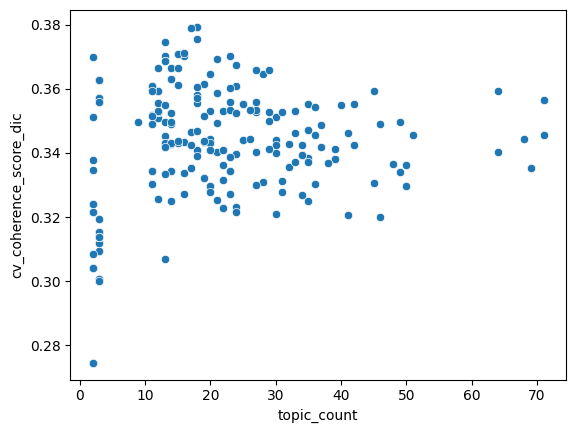

In [ ]:
sns.scatterplot(data=bertopic_cv, x="topic_count", y="cv_coherence_score_dic")

In [ ]:
def cv_plot(df, topic_count=10, metric = 'all')

In [ ]:
bertopic_cv_less_20 = bertopic_cv[bertopic_cv['topic_count'] <= 20]
bertopic_cv_less_20['diff_mean_med_topic_count'] = bertopic_cv_less_20['mean_topic_count'] - bertopic_cv_less_20['median_topic_count']
bertopic_mean_median_coherence = bertopic_cv_less_20.groupby(['topic_count']).agg(['mean', 'median'])['cv_coherence_score_dic']
bertopic_mean_median_topic_count = bertopic_cv_less_20.groupby(['topic_count']).agg(['mean', 'median'])['diff_mean_med_topic_count']
bertopic_mean_median_outlier= bertopic_cv_less_20.groupby(['topic_count']).agg(['mean', 'median'])['outlier_perc']
ccv_1 = pd.merge(bertopic_mean_median_coherence, bertopic_mean_median_topic_count, left_index=True, right_index=True)
ccv_2 = pd.merge(ccv_1, bertopic_mean_median_outlier, left_index=True, right_index=True)
# ccv_2
ccv_2['mean_x'] = ccv_2['mean_x'].apply(lambda x: x*100)
ccv_2['median_x'] = ccv_2['median_x'].apply(lambda x: x*100)
# ccv_2

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=ccv_2.index, y=ccv_2['mean_x'],
                    mode='lines',
                    name='mean_coherence'))

fig.add_trace(go.Scatter(x=ccv_2.index, y=ccv_2['median_x'],
                    mode='lines+markers',
                    name='median_coherence'))

fig.add_trace(go.Scatter(x=ccv_2.index, y=ccv_2['mean_y'],
                    mode='lines',
                    name='mean_of_diff_mean_median_topic_count'))

fig.add_trace(go.Scatter(x=ccv_2.index, y=ccv_2['median_y'],
                    mode='lines+markers',
                    name='median_of_diff_mean_median_topic_count'))

fig.add_trace(go.Scatter(x=ccv_2.index, y=ccv_2['mean'],
                    mode='lines',
                    name='mean_outlier_perc'))

fig.add_trace(go.Scatter(x=ccv_2.index, y=ccv_2['median'],
                    mode='lines+markers',
                    name='median_outlier_perc'))

fig.update_layout(
    xaxis_title="Topics",
    yaxis_title="Ave. cv_coherence score",
    title= q + ': ' + df.columns[1]
)

fig.show()

In [ ]:
bertopic_mean_median_npmicoherence = bertopic_cv_less_20.groupby(['topic_count']).agg(['mean', 'median'])['cnpmi_coherence_score_dic']
bertopic_mean_median_npmicoherence.rename(columns = {'mean': 'npmi_mean',
                                           'median': 'npmi_median'}, inplace=True)

fig = go.Figure()

fig.add_trace(go.Scatter(x=bertopic_mean_median_npmicoherence.index, y=bertopic_mean_median_npmicoherence['npmi_mean'],
                    mode='lines',
                    name='npmi_mean_coherence'))

fig.add_trace(go.Scatter(x=bertopic_mean_median_npmicoherence.index, y=bertopic_mean_median_npmicoherence['npmi_median'],
                    mode='lines+markers',
                    name='npmi_median_coherence'))

fig.update_layout(
    xaxis_title="Topics",
    yaxis_title="npmi_coherence score",
    title= q + ': ' + df.columns[1]
)

fig.show()

In [ ]:
bertopic_mean_median_umasscoherence = bertopic_cv_less_20.groupby(['topic_count']).agg(['mean', 'median'])['umass_coherence_score_dic']
bertopic_mean_median_umasscoherence.rename(columns = {'mean': 'umass_mean',
                                           'median': 'umass_median'}, inplace=True)

bertopic_mean_median_cucicoherence = bertopic_cv_less_20.groupby(['topic_count']).agg(['mean', 'median'])['cuci_coherence_score_dic']
bertopic_mean_median_cucicoherence.rename(columns = {'mean': 'cuci_mean',
                                           'median': 'cuci_median'}, inplace=True)

fig = go.Figure()

fig.add_trace(go.Scatter(x=bertopic_mean_median_umasscoherence.index, y=bertopic_mean_median_umasscoherence['umass_mean'],
                    mode='lines',
                    name='umass_mean_coherence'))

fig.add_trace(go.Scatter(x=bertopic_mean_median_umasscoherence.index, y=bertopic_mean_median_umasscoherence['umass_median'],
                    mode='lines+markers',
                    name='umass_median_coherence'))

fig.add_trace(go.Scatter(x=bertopic_mean_median_cucicoherence.index, y=bertopic_mean_median_cucicoherence['cuci_mean'],
                    mode='lines',
                    name='cuci_mean_coherence'))

fig.add_trace(go.Scatter(x=bertopic_mean_median_cucicoherence.index, y=bertopic_mean_median_cucicoherence['cuci_median'],
                    mode='lines+markers',
                    name='cuci_median_coherence'))

fig.update_layout(
    xaxis_title="Topics",
    yaxis_title="umass_cuci_coherence score",
    title= q + ': ' + df.columns[1]
)

fig.show()

In [ ]:
bertopic_mean_median_td = bertopic_cv_less_20.groupby(['topic_count']).agg(['mean', 'median'])['topic_diversity_score_dic']
bertopic_mean_median_td.rename(columns = {'mean': 'td_mean',
                                           'median': 'td_median'}, inplace=True)

fig = go.Figure()

fig.add_trace(go.Scatter(x=bertopic_mean_median_td.index, y=bertopic_mean_median_td['td_mean'],
                    mode='lines',
                    name='tl_mean_coherence'))

fig.add_trace(go.Scatter(x=bertopic_mean_median_td.index, y=bertopic_mean_median_td['td_median'],
                    mode='lines+markers',
                    name='tl_median_coherence'))

fig.update_layout(
    xaxis_title="Topics",
    yaxis_title="Topic Diversity score",
    title= q + ': ' + df.columns[1]
)

fig.show()

In [ ]:
bertopic_mean_median_kl = bertopic_cv_less_20.groupby(['topic_count']).agg(['mean', 'median'])['kldivergence_score_dic']
bertopic_mean_median_kl.rename(columns = {'mean': 'kl_mean',
                                           'median': 'kl_median'}, inplace=True)

fig = go.Figure()

fig.add_trace(go.Scatter(x=bertopic_mean_median_kl.index, y=bertopic_mean_median_kl['kl_mean'],
                    mode='lines',
                    name='kl_mean_coherence'))

fig.add_trace(go.Scatter(x=bertopic_mean_median_kl.index, y=bertopic_mean_median_kl['kl_median'],
                    mode='lines+markers',
                    name='kl_median_coherence'))

fig.update_layout(
    xaxis_title="Topics",
    yaxis_title="KL Divergence score",
    title= q + ': ' + df.columns[1]
)

fig.show()

In [ ]:
bertopic_mean_median_js = bertopic_cv_less_20.groupby(['topic_count']).agg(['mean', 'median'])['js_score_dic']
bertopic_mean_median_js.rename(columns = {'mean': 'js_mean',
                                           'median': 'js_median'}, inplace=True)

bertopic_mean_median_rbo = bertopic_cv_less_20.groupby(['topic_count']).agg(['mean', 'median'])['rbo_score_dic']
bertopic_mean_median_rbo.rename(columns = {'mean': 'rbo_mean',
                                           'median': 'rbo_median'}, inplace=True)

fig = go.Figure()

fig.add_trace(go.Scatter(x=bertopic_mean_median_js.index, y=bertopic_mean_median_js['js_mean'],
                    mode='lines',
                    name='js_mean_coherence'))

fig.add_trace(go.Scatter(x=bertopic_mean_median_js.index, y=bertopic_mean_median_js['js_median'],
                    mode='lines+markers',
                    name='js_median_coherence'))

fig.add_trace(go.Scatter(x=bertopic_mean_median_rbo.index, y=bertopic_mean_median_rbo['rbo_mean'],
                    mode='lines',
                    name='rbo_mean_coherence'))

fig.add_trace(go.Scatter(x=bertopic_mean_median_rbo.index, y=bertopic_mean_median_rbo['rbo_median'],
                    mode='lines+markers',
                    name='rbo_median_coherence'))

fig.update_layout(
    xaxis_title="Topics",
    yaxis_title="Jaccard Similarity & RBO score",
    title= q + ': ' + df.columns[1]
)

fig.show()

In [ ]:
# First, filter rows where topic_count is between 11 and 20 inclusive
filtered_df = bertopic_cv[(bertopic_cv['topic_count'] >= 11) & (bertopic_cv['topic_count'] <= 20)]

# Then, group by 'topic_count' and get the max 'topic_diversity_score_dic' for each group
max_values = filtered_df.groupby('topic_count')['topic_diversity_score_dic'].max()

import plotly.graph_objects as go

# Assuming max_values is a pandas Series with the topic_count as index and max diversity score as values
df = max_values.reset_index()

# Renaming the columns for better visualization
df.columns = ['Topic', 'Topic Diversity Score']

# Round the 'Topic Diversity Score' to 4 decimal places
df['Topic Diversity Score'] = df['Topic Diversity Score'].round(4)

# Create the line plot
line = go.Scatter(x=df['Topic'], y=df['Topic Diversity Score'], mode='lines', name='TD Scores')

# Create the text labels
labels = go.Scatter(x=df['Topic'], y=df['Topic Diversity Score'], mode='text', text=df['Topic Diversity Score'], textposition='top center')

# Create the figure and add the line and labels
fig = go.Figure(data=[line, labels])

# Add title and labels
fig.update_layout(title='Highest Topic Diversity Score for Each Topic', xaxis_title='Topic', yaxis_title='Topic Diversity Score')

# Show the plot
fig.show()

#### Pick params

In [ ]:
index = 121
# 121 - 18 topics
# 196 - 9 topics
#  topics: 11 index: 41
#  Q4: 291
params = bertopic_cv.loc[index].to_list()[5:9]
params

[7.0, 0.075, 7.0, 3.0]

### Init Custom Model

In [ ]:
docs_bert = bertopic['for_topic_model'].to_list()
n = len(docs_bert)
n

540

#### 3D plot function

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from umap import UMAP
from typing import List

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic


def visualize_documents(topic_model,
                        docs: List[str],
                        topics: List[int] = None,
                        embeddings: np.ndarray = None,
                        reduced_embeddings: np.ndarray = None,
                        sample: float = None,
                        hide_annotations: bool = False,
                        hide_document_hover: bool = False,
                        custom_labels: bool = False,
                        width: int = 1200,
                        height: int = 750):
    """ Visualize documents and their topics in 2D
    Arguments:
        topic_model: A fitted BERTopic instance.
        docs: The documents you used when calling either `fit` or `fit_transform`
        topics: A selection of topics to visualize.
                Not to be confused with the topics that you get from `.fit_transform`.
                For example, if you want to visualize only topics 1 through 5:
                `topics = [1, 2, 3, 4, 5]`.
        embeddings: The embeddings of all documents in `docs`.
        reduced_embeddings: The 2D reduced embeddings of all documents in `docs`.
        sample: The percentage of documents in each topic that you would like to keep.
                Value can be between 0 and 1. Setting this value to, for example,
                0.1 (10% of documents in each topic) makes it easier to visualize
                millions of documents as a subset is chosen.
        hide_annotations: Hide the names of the traces on top of each cluster.
        hide_document_hover: Hide the content of the documents when hovering over
                             specific points. Helps to speed up generation of visualization.
        custom_labels: Whether to use custom topic labels that were defined using
                       `topic_model.set_topic_labels`.
        width: The width of the figure.
        height: The height of the figure.
    Examples:
    To visualize the topics simply run:
    ```python
    topic_model.visualize_documents(docs)
    ```
    Do note that this re-calculates the embeddings and reduces them to 2D.
    The advised and prefered pipeline for using this function is as follows:
    ```python
    from sklearn.datasets import fetch_20newsgroups
    from sentence_transformers import SentenceTransformer
    from bertopic import BERTopic
    from umap import UMAP
    # Prepare embeddings
    docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = sentence_model.encode(docs, show_progress_bar=False)
    # Train BERTopic
    topic_model = BERTopic().fit(docs, embeddings)
    # Reduce dimensionality of embeddings, this step is optional
    # reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    # Run the visualization with the original embeddings
    topic_model.visualize_documents(docs, embeddings=embeddings)
    # Or, if you have reduced the original embeddings already:
    topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)
    ```
    Or if you want to save the resulting figure:
    ```python
    fig = topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)
    fig.write_html("path/to/file.html")
    ```
    <iframe src="../../getting_started/visualization/documents.html"
    style="width:1000px; height: 800px; border: 0px;""></iframe>
    """
    topic_per_doc = topic_model.topics_

    # Sample the data to optimize for visualization and dimensionality reduction
    if sample is None or sample > 1:
        sample = 1

    indices = []
    for topic in set(topic_per_doc):
        s = np.where(np.array(topic_per_doc) == topic)[0]
        size = len(s) if len(s) < 100 else int(len(s) * sample)
        indices.extend(np.random.choice(s, size=size, replace=False))
    indices = np.array(indices)

    df = pd.DataFrame({"topic": np.array(topic_per_doc)[indices]})
    df["doc"] = [docs[index] for index in indices]
    df["topic"] = [topic_per_doc[index] for index in indices]

    # Extract embeddings if not already done
    if sample is None:
        if embeddings is None and reduced_embeddings is None:
            embeddings_to_reduce = topic_model._extract_embeddings(df.doc.to_list(), method="document")
        else:
            embeddings_to_reduce = embeddings
    else:
        if embeddings is not None:
            embeddings_to_reduce = embeddings[indices]
        elif embeddings is None and reduced_embeddings is None:
            embeddings_to_reduce = topic_model._extract_embeddings(df.doc.to_list(), method="document")

    # Reduce input embeddings
    if reduced_embeddings is None:
        umap_model = UMAP(n_neighbors=10, n_components=3, min_dist=0.0, metric='cosine').fit(embeddings_to_reduce)
        embeddings_2d = umap_model.embedding_
    elif sample is not None and reduced_embeddings is not None:
        embeddings_2d = reduced_embeddings[indices]
    elif sample is None and reduced_embeddings is not None:
        embeddings_2d = reduced_embeddings

    unique_topics = set(topic_per_doc)
    if topics is None:
        topics = unique_topics

    # Combine data
    df["x"] = embeddings_2d[:, 0]
    df["y"] = embeddings_2d[:, 1]
    df["z"] = embeddings_2d[:, 2]

    # Prepare text and names
    if topic_model.custom_labels_ is not None and custom_labels:
        names = [topic_model.custom_labels_[topic + topic_model._outliers] for topic in unique_topics]
    else:
        names = [f"{topic}_" + "_".join([word for word, value in topic_model.get_topic(topic)][:3]) for topic in unique_topics]

    # Visualize
    fig = go.Figure()

    # Outliers and non-selected topics
    non_selected_topics = set(unique_topics).difference(topics)
    if len(non_selected_topics) == 0:
        non_selected_topics = [-1]

    selection = df.loc[df.topic.isin(non_selected_topics), :]
    selection["text"] = ""
    selection.loc[len(selection), :] = [None, None, selection.x.mean(), selection.y.mean(), selection.z.mean(), "Other documents"]

    fig.add_trace(
        go.Scatter3d(
            x=selection.x,
            y=selection.y,
            z=selection.z,
            hovertext=selection.doc if not hide_document_hover else None,
            hoverinfo="text",
            mode='markers+text',
            name="other",
            showlegend=False,
            marker=dict(color='#CFD8DC', size=5, opacity=0.5)
        )
    )

    # Selected topics
    for name, topic in zip(names, unique_topics):
        if topic in topics and topic != -1:
            selection = df.loc[df.topic == topic, :]
            selection["text"] = ""

            if not hide_annotations:
                selection.loc[len(selection), :] = [None, None, selection.x.mean(), selection.y.mean(),selection.z.mean(), name]

            fig.add_trace(
                go.Scatter3d(
                    x=selection.x,
                    y=selection.y,
                    z=selection.z,
                    hovertext=selection.doc if not hide_document_hover else None,
                    hoverinfo="text",
                    text=selection.text,
                    mode='markers+text',
                    name=name,
                    textfont=dict(
                        size=12,
                    ),
                    marker=dict(size=5, opacity=0.5)
                )
            )

    # Add grid in a 'plus' shape
    x_range = (df.x.min() - abs((df.x.min()) * .15), df.x.max() + abs((df.x.max()) * .15))
    y_range = (df.y.min() - abs((df.y.min()) * .15), df.y.max() + abs((df.y.max()) * .15))
    fig.add_shape(type="line",
                  x0=sum(x_range) / 2, y0=y_range[0], x1=sum(x_range) / 2, y1=y_range[1],
                  line=dict(color="#CFD8DC", width=2))
    fig.add_shape(type="line",
                  x0=x_range[0], y0=sum(y_range) / 2, x1=x_range[1], y1=sum(y_range) / 2,
                  line=dict(color="#9E9E9E", width=2))
    fig.add_annotation(x=x_range[0], y=sum(y_range) / 2, text="D1", showarrow=False, yshift=10)
    fig.add_annotation(y=y_range[1], x=sum(x_range) / 2, text="D2", showarrow=False, xshift=10)

    # Stylize layout
    fig.update_layout(
        template="simple_white",
        title={
            'text': "<b>Documents and Topics",
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        width=width,
        height=height
    )

    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    return fig

#### Functions

In [ ]:
def embedding_senttrans(model): # all-MiniLM-L6-v2, all-MiniLM-L12-v2, all-mpnet-base-v2, msmarco-distilbert-base-v4
    '''Returns an embedding model.

    This function takes a pre-trained SBERT model.
    '''
    embedding_model = SentenceTransformer(model_name_or_path=model)
    return embedding_model

def umap(n_neighbors=5, n_components=2, min_dist=1, metric='manhattan'):
    '''Returns a UMAP model.

    This function takes specific parameters for UMAP.
    '''
    umap_model = UMAP(n_neighbors=n_neighbors, n_components=n_components,
                      min_dist=min_dist, random_state=42, metric=metric)
    return umap_model

def hdbscan(min_cluster_size=10, min_samples=3):
    '''Returns an HDBSCAN model

    This function takes specific parameters for HDBSCAN
    '''
    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,
                            prediction_data=True, gen_min_span_tree=True)
    return hdbscan_model

words_stop = stopwords.words('english')
custom_stop_words = ['lack', 'culture', 'also', 'able', 'like', 'liked',
                     'say', 'think', 'already', 'would', 'qa', 'us',
                     'also', 'things', 'want', 'yes', 'no', 'thank',
                     'you', 'thank you', 'given', 'lot', 'sm']

def count_vec(ngram_range=1, stop_words=words_stop):
    '''Returns a CountVectorizer model

    This function takes an upper limit ngram from which no. of words can be grouped.
    It also takes a custom or fixed stop words to include in the model.
    '''
    vectorizer_model = CountVectorizer(ngram_range=(1, ngram_range), stop_words=stop_words)
    return vectorizer_model

def representation_model():

    # Create your representation model
    pos = PartOfSpeech("en_core_web_sm", top_n_words=30)
    mmr = MaximalMarginalRelevance(diversity=.4, top_n_words=8)

    representation_model = [pos, mmr]

    # prompt = "I have a topic described by the following keywords: [KEYWORDS]. Based on the previous keywords, what is this topic about?"
    # # Create your representation model
    # generator = pipeline('text2text-generation', model='google/flan-t5-base')
    # aspect_model1 = TextGeneration(generator)

    # representation_model = {
    #     "Main": main_representation,
    #     "Aspect1": aspect_model1
    # }
    return representation_model

##### Vizs function

In [ ]:
def bert_viz(bertopic_model, documents, timestamp=[], viz='tree', doc_embeddings=[]):
    '''Returns visualizations provided / built-in by BERTopic

    This functions takes a bertopic model and the documents used
    for topic modeling.
    '''
    if viz == '3d':
        idm = visualize_documents(bertopic_model,
                            docs = documents,
                            topics = None,
                            embeddings = doc_embeddings,
                            reduced_embeddings = None,
                            sample = None,
                            hide_annotations = False,
                            hide_document_hover = False,
                            custom_labels = False,
                            width = 1200,
                            height = 750)
        return idm

    elif viz == 'hierarchical':
        hierarchical_topics = bertopic_model.hierarchical_topics(documents)
        hierarchical = bertopic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
        return hierarchical

    elif viz == 'tree':
        hierarchical_topics = bertopic_model.hierarchical_topics(documents)
        tree = bertopic_model.get_topic_tree(hierarchical_topics)
        print(tree)

    elif viz == '2d':
        d2 = bertopic_model.visualize_documents(documents)
        return d2

    elif viz == 'heatmap':
        heatmap = bertopic_model.visualize_heatmap()
        return heatmap

    elif viz == 'dynamic_tm':
        topics_over_time = bertopic_model.topics_over_time(docs=documents,
                                                    timestamps=timestamp,
                                                    global_tuning=False,
                                                    evolution_tuning=False,
                                                    nr_bins=50)

        tot = bertopic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)
        return topics_over_time, tot

In [ ]:
def bert_model(documents, embedding_method, dim_reduc_method,
               clustering_method, vectorizer_method, representation_method,
               nr_topics=None):
    '''Returns the bertopic model, dominant topic for each documents,
    and the probability distribution of topics for each documents.

    This function takes custom models for embedding, dimentionality reduction,
    clustering, and vectorizer.
    '''

    bert_model = BERTopic(
    embedding_model=embedding_method,
    umap_model=dim_reduc_method,
    hdbscan_model=clustering_method,
    vectorizer_model=vectorizer_method,
    representation_model = representation_method,
    nr_topics=nr_topics,
    top_n_words=8,
    language='english',
    calculate_probabilities=True,
    verbose=True,
    )

    topics, probs = bert_model.fit_transform(documents)

    return bert_model, topics, probs

#### Custom Model

In [ ]:
sbert_model = 'all-mpnet-base-v2'

In [ ]:
cust_model, topics, probs = bert_model(documents = docs_bert,
                                       embedding_method = embedding_senttrans(sbert_model), # all-mpnet-base-v2
                                       dim_reduc_method = umap(n_neighbors = round(params[0]), n_components = 3,
                                            min_dist = params[1], metric = 'cosine'),
                                       clustering_method = hdbscan(min_cluster_size = round(params[2]),
                                              min_samples = round(params[3])),
                                       vectorizer_method = count_vec(ngram_range = 2,
                                                stop_words = words_stop + custom_stop_words),
                                       representation_method = representation_model()
                                      )

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-06-05 03:52:29,400 - BERTopic - Transformed documents to Embeddings
2023-06-05 03:52:31,352 - BERTopic - Reduced dimensionality
2023-06-05 03:52:31,393 - BERTopic - Clustered reduced embeddings


In [ ]:
topic_words = [[word for word, prob in cust_model.get_topic(topic)] for topic in set(topics) if topic != -1]

In [ ]:
topic_words

[['employees',
  'salary',
  'benefits',
  'compensation',
  'company',
  'manager_tags',
  'flexibility',
  'bonuses'],
 ['teams',
  'collaboration',
  'projects',
  'tribe',
  'business',
  'different groups',
  'stakeholders',
  'timelines'],
 ['company',
  'teams',
  'leadership',
  'processes',
  'top',
  'levels',
  'onboarding',
  'organization'],
 ['gcash',
  'products',
  'customers',
  'need',
  'financial',
  'company',
  'financial inclusion',
  'immediate_supervisor_tag'],
 ['data',
  'deployment',
  'efficient',
  'approvals',
  'tech',
  'faster turnaround',
  'document',
  'reports'],
 ['balance',
  'workloads',
  'headcount',
  'sure',
  'increase',
  'management',
  'hybrid setup',
  'long hours'],
 ['skills',
  'certifications',
  'diversity',
  'manager_tags',
  'roles',
  'projects',
  'management',
  'external trainings'],
 ['customer',
  'service',
  'scam',
  'complaints',
  'support',
  'cx',
  'temporary suspension',
  'timely response'],
 ['values',
  'busine

In [ ]:
cust_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,116,-1_support_customers_service_app,"[support, customers, service, app, changes, pr...",[operating efficiency in terms of people respo...
1,0,62,0_employees_salary_benefits_compensation,"[employees, salary, benefits, compensation, co...",[complete and total care of employees will res...
2,1,55,1_teams_collaboration_projects_tribe,"[teams, collaboration, projects, tribe, busine...",[business representatives such as product mana...
3,2,50,2_company_teams_leadership_processes,"[company, teams, leadership, processes, top, l...",[we need more diversity in voice and decision ...
4,3,42,3_gcash_products_customers_need,"[gcash, products, customers, need, financial, ...",[let's continue the rigor and passion to deliv...
5,4,26,4_data_deployment_efficient_approvals,"[data, deployment, efficient, approvals, tech,...",[there are issues when performing our tasks an...
6,5,22,5_balance_workloads_headcount_sure,"[balance, workloads, headcount, sure, increase...",[while i understand that the growth of the com...
7,6,22,6_skills_certifications_diversity_manager_tags,"[skills, certifications, diversity, manager_ta...",[we grew the company so fast since the pandemi...
8,7,20,7_customer_service_scam_complaints,"[customer, service, scam, complaints, support,...",[customer support especially in terms of insta...
9,8,20,8_values_business_priority_right enablers,"[values, business, priority, right enablers, c...","[i believe to serve our customers effectively,..."


In [ ]:
# Prepare embeddings
sentence_model = embedding_senttrans(sbert_model)
doc_embeddings = sentence_model.encode(docs_bert, show_progress_bar=False)

In [ ]:
bert_viz(cust_model, docs_bert, viz='3d', doc_embeddings=doc_embeddings)

In [ ]:
bert_viz(cust_model, docs_bert, viz='2d')

In [ ]:
bert_viz(cust_model, docs_bert, viz='hierarchical')

100%|██████████| 17/17 [00:04<00:00,  4.24it/s]


#### Save Model

In [ ]:
cust_model.save('/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/models/bertopic_'+q+'.model', save_embedding_model=False)

### Evaluation

In [ ]:
max_probs = []

for i in range(0, len(docs_bert)):
  max_probs.append(max(probs[i]))

In [ ]:
# Use this if we want the outliers as is

bertopic['topic'] = topics
bertopic['topic_probability'] = max_probs

# Use this if we update the topics to include some outliers

# bertopic['topic'] = new_topics
# bertopic['topic_probability'] = max_probs

Text(0, 0.5, 'Number of documents')

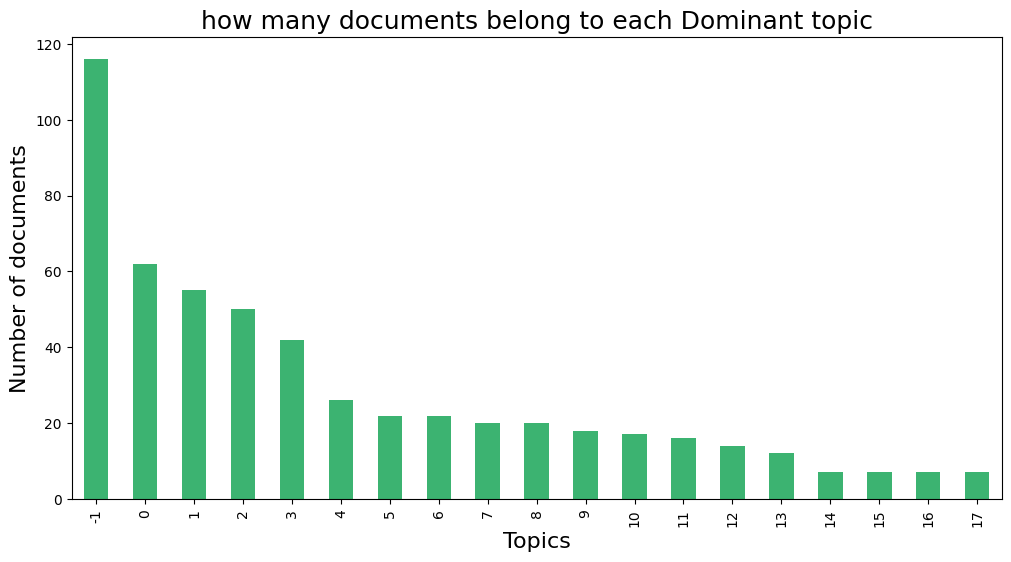

In [ ]:
topic_counts = bertopic["topic"].value_counts()
topic_counts.plot(kind = "bar", color = "mediumseagreen", figsize = (12,6))
plt.title("how many documents belong to each Dominant topic", size = 18)
plt.xlabel("Topics", size = 16)
plt.ylabel("Number of documents", size = 16)

In [ ]:
print('No. of outliers:', len(bertopic[bertopic['topic'] == -1]))
print('% of outliers:', len(bertopic[bertopic['topic'] == -1])/len(bertopic))

No. of outliers: 116
% of outliers: 0.21481481481481482


#### Add main topic

In [ ]:
bert_viz(cust_model, docs_bert, viz='hierarchical')

100%|██████████| 17/17 [00:04<00:00,  3.47it/s]


In [ ]:
# Q1
main_topics = {
                'A': [7, 8, 10, 16],
                'B': [0, 5, 13],
                'C': [1, 2, 3, 6, 9, 11],
                'D': [4, 12, 14, 15, 17]
                }


def main_topic(x, main_topics_dic):

    for k, v in main_topics_dic.items():
        if x in v:
            return k


In [ ]:
bertopic['main_topic'] = bertopic['topic'].apply(lambda x: main_topic(x, main_topics))

In [ ]:
for i in main_topics.keys():
    print('Main Topic: ' + str(i))
    print(bertopic[bertopic['main_topic'] == i]['topic'].value_counts(), '\n')

Main Topic: A
8     20
7     20
10    17
16     7
Name: topic, dtype: int64 

Main Topic: B
0     62
5     22
13    12
Name: topic, dtype: int64 

Main Topic: C
1     55
2     50
3     42
6     22
9     18
11    16
Name: topic, dtype: int64 

Main Topic: D
4     26
12    14
14     7
15     7
17     7
Name: topic, dtype: int64 



#### Add top word representation

In [ ]:
bertopic['Sub-topic'] = bertopic['topic'].apply(lambda x: str(x)+'_'+'_'.join([word for word, _ in cust_model.get_topic(x)]))

In [ ]:
bertopic.head()

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model,cleaned,cleaned_joined,length,topic,topic_probability,main_topic,Sub-topic
0,Leadership,"Towards autonomous team, leadership should tru...","towards autonomous team, leadership should tru...","[autonomous, team, leadership, trust, nurture,...",autonomous team leadership trust nurture self ...,22,2,0.313413,C,2_company_teams_leadership_processes_top_level...
2,Leadership,LT should be the first people in championing e...,lt should be the first people in championing e...,"[lt, people, champion, employee, recognition, ...",lt people champion employee recognition program,12,0,0.321857,B,0_employees_salary_benefits_compensation_compa...
3,Leadership,I've been here for a year. There are things do...,i've been here for a year. there are things do...,"[year, thing, lot, thing, inefficient, choose,...",year thing lot thing inefficient choose leader...,45,2,1.000000,C,2_company_teams_leadership_processes_top_level...
4,Leadership,"People managers and leaders must talk about, r...",people manager_tags and leaders must talk abou...,"[people, manager_tag, leader, talk, model, val...",people manager_tag leader talk model value way...,36,3,0.086893,C,3_gcash_products_customers_need_financial_comp...
5,Leadership,Leaders should be role models. They should be ...,leaders should be role models. they should be ...,"[leader, role, model, appoint, base, competenc...",leader role model appoint base competence know...,35,2,1.000000,C,2_company_teams_leadership_processes_top_level...


##### Export df to CSV

In [ ]:
bertopic.to_csv(r'/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topics/bertopic_'+q+'.csv', index=False)

# Summarizer

https://docs.cohere.com/docs/models

In [ ]:
import time

def inf_s(df, model):
    # topic = []
    summary = []
    topic_words = [[word for word, prob in model.get_topic(topic)] for topic in set(model.topics_) if topic != -1]

    for i in [17]:
        KEYWORDS = topic_words[i]
        DOCUMENTS = df[df['topic'] == i]['for_topic_model'].to_list()

        print('Topic:', i)

        if len(DOCUMENTS) > 10:

            infer_summarize = f'''
            Summarize what is discussed in the documents: {DOCUMENTS} and the following keywords: {KEYWORDS} in 3 sentences and do not repeat the documents.

            '''

            while True:
                try:
                    response = co.generate(
                    prompt=infer_summarize,
                    temperature = 2,
                    max_tokens = 150,
                    num_generations = 1
                    # frequency_penalty = 0.5,
                    # presence_penalty = 0.5
                    )
                    summary.append(str(response[0]))
                    break
                except cohere.CohereAPIError:
                    print("Reached API limit. Waiting for 60 seconds...")
                    time.sleep(60)

        else:

            infer_summarize = f'''
            Summarize what is discussed in the documents: {' '.join(DOCUMENTS)} and the following keywords: {' '.join(KEYWORDS)} in 3 sentences and do not repeat the documents.

            '''

            while True:
                try:
                    response = co.generate(
                    prompt=infer_summarize,
                    temperature = 2,
                    max_tokens = 150,
                    num_generations = 1
                    # frequency_penalty = 0.5,
                    # presence_penalty = 0.5
                    )
                    summary.append(str(response[0]))
                    break
                except cohere.CohereAPIError:
                    print("Reached API limit. Waiting for 60 seconds...")
                    time.sleep(60)



        print('\n')

    return summary

In [ ]:
summary = inf_s(bertopic, cust_model)

Topic: 17


Your text contains a trailing whitespace, which has been trimmed to ensure high quality generations.


In [ ]:
import time

def inf_t(df, model):
    topic = []
    topic_words = [[word for word, prob in model.get_topic(topic)] for topic in set(model.topics_) if topic != -1]

    for i in range(0, 18):
        KEYWORDS = topic_words[i]
        DOCUMENTS = df[df['topic'] == i]['for_topic_model'].to_list()

        infer_topic = f'''I have a topic that is described by the following documents: {DOCUMENTS}
        What do you think is the topic all about? Create a headline for the topic.
        '''

        print('Topic:', i)

        while True:
            try:
                response = co.generate(
                model='summarize-xlarge',
                prompt=infer_topic,
                temperature = 1,
                max_tokens = 500,
                num_generations = 1
                )
                topic.append(str(response[0]))
                break
            except cohere.CohereAPIError:
                print("Reached API limit. Waiting for 60 seconds...")
                time.sleep(60)

        print('\n')

    return topic

In [ ]:
topic = inf_t(bertopic, cust_model)

## Manually infer topic

In [ ]:
topic

['Employee Compensation and Benefits',
 'collaboration',
 'from the ground up',
 'Promoting employees based on tenure',
 'faster turn around time and more efficiency',
 'balancing workload and work-life',
 'Training, learning and development',
 'Call center/hotline services',
 'Serve your customers',
 'Topic: how to improve our company',
 'Learning from customers for better products and services',
 'Time to improve customer support',
 'Efficiency',
 'Headline: Work from home',
 'Top-down communication is not timely enough',
 "'Process improvements and standardizations'",
 'A review of a customer service and engagement strategy',
 'The topic is about improving internal processes.']

In [ ]:
sub_topic_name = ['Improve Compensation and Benefits',
         'Collaboration within Company',
         'Leadership',
         'Improve Mobile App',
         'Operating Efficiency',
         'Importance of Work-life Balance',
         'Learning & Development',
         'Improve Customer Service',
         'Serve and Take care of Customers',
         'Effect of Internal Reorganization',
         'Improve Products & Services for Customers',
         'Product Issues Internally',
         'Working Efficiency',
         'Work from home',
         'Information Cascade',
         'Improve Processes',
         'Increase Customer Engagement',
         'Streamline Internal Processes'
         ]

In [ ]:
sum_data = pd.DataFrame({'topic': list(set(cust_model.topics_))[:-1],
              'inferred_topic': topic,
              'inferred_summary': summary,
              'sub-topic_name': sub_topic_name})

In [ ]:
sum_data

,topic,inferred_topic,inferred_summary,sub-topic_name
0,0,Employee Compensation and Benefits,The feedback from employees contains a mix of ...,Improve Compensation and Benefits
1,1,collaboration,The collaboration between different teams and ...,Collaboration
2,2,from the ground up,"towards autonomous team, leadership should tru...",Leadership
3,3,Promoting employees based on tenure,The people that are involved with gcash have s...,Improve Mobile App
4,4,faster turn around time and more efficiency,The list of documents contains issues and solu...,Operating Efficiency
5,5,balancing workload and work-life,The employees in this company are continuously...,Importance of Work-life Balance
6,6,"Training, learning and development",The documents contain a wide range of suggesti...,Learning & Development
7,7,Call center/hotline services,The documents mention several recommendations ...,Improve Customer Service
8,8,Serve your customers,The information above is a collection of quote...,Serve and take care of Customers
9,9,Topic: how to improve our company,The documents discuss issues that may arise wh...,Role Management


## Export df to CSV

In [ ]:
sum_data.to_csv(r'/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topic_summary/topic_sum_'+q+'.csv', index=False)

# Assign length 1-2 words to Topics

For Future Iterations, might be worth checking if using cosine-similarity gave more explainable result than the model.transform

In [ ]:
feedbacks = list(sep_12w[sep_12w.columns[1]].values)

In [ ]:
def assign_12w(feedback, main_topics_dic):

    topic = []
    topic_probability = []
    main_topic = []
    sub_topic = []

    for item in feedback:
        # Print the item
        print('Feedback: ' + item)

        # Wait for the user to input a number, then add that number to the list
        # Use a while loop to make sure user inputs a valid number
        while True:
            try:
                num = int(input("Please enter a topic number to assign to this feeback: "))
                break
            except ValueError:
                print("That's not a valid number. Please enter a valid number.")

        topic.append(num)

        # Get topic probability
        topicc, probs = cust_model.transform(item)
        topic_probability.append(max(probs[0]))

        print('\n')

        # Get main_topic
    for i in topic:
        for key, value in main_topics_dic.items():
            if i in value:
                main_topic.append(key)
                break    # Once we find a match, no need to check other dictionary items
        else:
            main_topic.append(None)  # If no match is found in the dictionary, append None


        # Get Sub-topic Keywords
        keywords_output = '{}_{}'.format(i, '_'.join(t[0] for t in cust_model.get_topic(i)))
        sub_topic.append(keywords_output)



    return topic, topic_probability, main_topic, sub_topic

In [ ]:
cust_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,116,-1_support_customers_service_app,"[support, customers, service, app, changes, pr...",[operating efficiency in terms of people respo...
1,0,62,0_employees_salary_benefits_compensation,"[employees, salary, benefits, compensation, co...",[complete and total care of employees will res...
2,1,55,1_teams_collaboration_projects_tribe,"[teams, collaboration, projects, tribe, busine...",[business representatives such as product mana...
3,2,50,2_company_teams_leadership_processes,"[company, teams, leadership, processes, top, l...",[we need more diversity in voice and decision ...
4,3,42,3_gcash_products_customers_need,"[gcash, products, customers, need, financial, ...",[let's continue the rigor and passion to deliv...
5,4,26,4_data_deployment_efficient_approvals,"[data, deployment, efficient, approvals, tech,...",[there are issues when performing our tasks an...
6,5,22,5_balance_workloads_headcount_sure,"[balance, workloads, headcount, sure, increase...",[while i understand that the growth of the com...
7,6,22,6_skills_certifications_diversity_manager_tags,"[skills, certifications, diversity, manager_ta...",[we grew the company so fast since the pandemi...
8,7,20,7_customer_service_scam_complaints,"[customer, service, scam, complaints, support,...",[customer support especially in terms of insta...
9,8,20,8_values_business_priority_right enablers,"[values, business, priority, right enablers, c...","[i believe to serve our customers effectively,..."


In [ ]:
sum_data

,topic,inferred_topic,inferred_summary,sub-topic_name
0,0,Employee Compensation and Benefits,The employees have suggested ways to improve t...,Improve Compensation and Benefits
1,1,collaboration,The information above contains collaboration a...,Collaboration within Company
2,2,from the ground up,The text contains opinions and feedback from e...,Leadership
3,3,Promoting employees based on tenure,The feedback from the customers of gcash is th...,Improve Mobile App
4,4,faster turn around time and more efficiency,The list of documents contains several complai...,Operating Efficiency
5,5,balancing workload and work-life,The documents talk about the importance of wor...,Importance of Work-life Balance
6,6,"Training, learning and development",The employees need more special skills trainin...,Learning & Development
7,7,Call center/hotline services,The information above is feedback provided to ...,Improve Customer Service
8,8,Serve your customers,Customer service is an integral part of any bu...,Serve and Take care of Customers
9,9,Topic: how to improve our company,"When employees are moved to a new department, ...",Effect of Internal Reorganization


In [ ]:
topic, topic_probability, main_topic, sub_topic = assign_12w(feedbacks, main_topics)

Feedback: Good Leadership
Please enter a topic number to assign to this feeback: 2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Balanced KPIs
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Change Management
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: More partnerships
Please enter a topic number to assign to this feeback: 1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Synergies more
Please enter a topic number to assign to this feeback: 1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: competitive salary
Please enter a topic number to assign to this feeback: 0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: SYSTEM ENHANCEMENT
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Clear roles
Please enter a topic number to assign to this feeback: 9


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Managing fraud
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Error-free product
Please enter a topic number to assign to this feeback: 11


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Preventing fraud
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Less bureaucracy
Please enter a topic number to assign to this feeback: 17


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Agility
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Good Job
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: More direction
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: After sales
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Car plan.
Please enter a topic number to assign to this feeback: 0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: car plan
Please enter a topic number to assign to this feeback: 0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: More bonus
Please enter a topic number to assign to this feeback: 0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Employee benefits
Please enter a topic number to assign to this feeback: 0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: More uptraining.
Please enter a topic number to assign to this feeback: 6


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Training
Please enter a topic number to assign to this feeback: 6


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
sep_12w['topic'] = topic
sep_12w['topic_probability'] = topic_probability
sep_12w['main_topic'] = main_topic
sep_12w['Sub-topic'] = sub_topic

In [ ]:
sep_12w.head(5)

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model,cleaned,cleaned_joined,length,topic,topic_probability,main_topic,Sub-topic
1,Leadership,Good Leadership,good leadership.,"[good, leadership]",good leadership,2,2,1.000000,C,2_company_teams_leadership_processes_top_level...
37,Performance Management,Balanced KPIs,balanced kpis.,[balanced],balanced,2,-1,0.067664,None,-1_support_customers_service_app_changes_proce...
57,Communication,Change Management,change management.,"[change, management]",change management,2,-1,0.087665,None,-1_support_customers_service_app_changes_proce...
115,Collaboration,More partnerships,more partnerships.,[partnership],partnership,2,1,0.224826,C,1_teams_collaboration_projects_tribe_business_...
120,Collaboration,Synergies more,synergies more.,[synergy],synergy,2,1,0.081805,C,1_teams_collaboration_projects_tribe_business_...


## Combine bertopic df & sep_12w df

In [ ]:
# Append df2 at the end of df1
bertopic = bertopic.append(sep_12w, ignore_index=True)

## Re-save bertopic df

In [ ]:
bertopic.to_csv(r'/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topics/bertopic_'+q+'.csv', index=False)

# Check outliers

For Future Iterations, might be worth checking if using cosine-similarity gave more explainable result than the model.transform

## Separate outliers

In [ ]:
bertopic_wo_outliers = bertopic[bertopic['topic'] != -1]

In [ ]:
bertopic_w_outliers = bertopic[bertopic['topic'] == -1][bertopic.columns[0: list(bertopic.columns).index('length')+1]]

In [ ]:
bertopic_w_outliers

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model,cleaned,cleaned_joined,length
495,Performance Management,Follow through on CDP,follow through on cdp.,['follow'],follow,4
496,Communication,Creation of a monthly enterprise newsletter.,creation of a monthly enterprise newsletter.,"['creation', 'monthly', 'enterprise', 'newslet...",creation monthly enterprise newsletter,6
497,Communication,We can be a bit more aggressive on how we mark...,we can be a bit more aggressive on how we mark...,"['bit', 'aggressive', 'market', 'app']",bit aggressive market app,20
498,Communication,Right message at the right time early on .,right message at the right time early on.,"['message', 'time', 'early']",message time early,8
499,Communication,"products, its process, availment and limitations","products, its process, availment and limitations.","['product', 'process', 'availment', 'limitation']",product process availment limitation,6
...,...,...,...,...,...,...
557,Operating Efficiency,Preventing fraud,preventing fraud.,"['prevent', 'fraud']",prevent fraud,2
558,Operating Efficiency,Agility,agility.,['agility'],agility,1
559,Values,Good Job,good job.,"['good', 'job']",good job,2
560,Goals & Objectives,More direction,more directions.,['direction'],direction,2


## Assign Outliers to Topics

In [ ]:
feedbacks_outliers = list(bertopic_w_outliers[bertopic_w_outliers.columns[1]].values)
assigned_wtw_topic = list(bertopic_w_outliers[bertopic_w_outliers.columns[0]].values)

In [ ]:
cust_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,116,-1_support_customers_service_app,"[support, customers, service, app, changes, pr...",[operating efficiency in terms of people respo...
1,0,62,0_employees_salary_benefits_compensation,"[employees, salary, benefits, compensation, co...",[complete and total care of employees will res...
2,1,55,1_teams_collaboration_projects_tribe,"[teams, collaboration, projects, tribe, busine...",[business representatives such as product mana...
3,2,50,2_company_teams_leadership_processes,"[company, teams, leadership, processes, top, l...",[we need more diversity in voice and decision ...
4,3,42,3_gcash_products_customers_need,"[gcash, products, customers, need, financial, ...",[let's continue the rigor and passion to deliv...
5,4,26,4_data_deployment_efficient_approvals,"[data, deployment, efficient, approvals, tech,...",[there are issues when performing our tasks an...
6,5,22,5_balance_workloads_headcount_sure,"[balance, workloads, headcount, sure, increase...",[while i understand that the growth of the com...
7,6,22,6_skills_certifications_diversity_manager_tags,"[skills, certifications, diversity, manager_ta...",[we grew the company so fast since the pandemi...
8,7,20,7_customer_service_scam_complaints,"[customer, service, scam, complaints, support,...",[customer support especially in terms of insta...
9,8,20,8_values_business_priority_right enablers,"[values, business, priority, right enablers, c...","[i believe to serve our customers effectively,..."


In [ ]:
sum_data

,topic,inferred_topic,inferred_summary,sub-topic_name
0,0,Employee Compensation and Benefits,The employees have suggested ways to improve t...,Improve Compensation and Benefits
1,1,collaboration,The information above contains collaboration a...,Collaboration
2,2,from the ground up,The text contains opinions and feedback from e...,Leadership
3,3,Promoting employees based on tenure,The feedback from the customers of gcash is th...,Improve Mobile App
4,4,faster turn around time and more efficiency,The list of documents contains several complai...,Operating Efficiency
5,5,balancing workload and work-life,The documents talk about the importance of wor...,Importance of Work-life Balance
6,6,"Training, learning and development",The employees need more special skills trainin...,Learning & Development
7,7,Call center/hotline services,The information above is feedback provided to ...,Improve Customer Service
8,8,Serve your customers,Customer service is an integral part of any bu...,Serve and Take care of Customers
9,9,Topic: how to improve our company,"When employees are moved to a new department, ...",Role Management


Now I see the advantage of BERTopic:
- If you would check the WTW tags 'communication', it actually about communication but has different context
- Whereas in bertopic it successfuly divided the context of the word communication into topics 'Information Cascade' & 'Increase Customer Engagement'
- Thus we have to still check the outliers since it will be good to manually assign them, atleast BERTopic gave us the capability to manually check the outliers and assign them to the corresponding topic

In [ ]:
# Delete ground_topic parameter if we don't have any basis like provided wtw topics

def assign_12w(feedback, main_topics_dic, ground_topic):

    topic = []
    topic_probability = []
    main_topic = []
    sub_topic = []

    for item, gt in zip(feedback, ground_topic):
        # Print the item
        print('Feedback: ' + item)
        print('WTW Topic Tag: ' + gt)


        # Wait for the user to input a number, then add that number to the list
        # Use a while loop to make sure user inputs a valid number
        while True:
            try:
                num = int(input("Please enter a topic number to assign to this feeback: "))
                break
            except ValueError:
                print("That's not a valid number. Please enter a valid number.")

        topic.append(num)

        # Get topic probability
        topicc, probs = cust_model.transform(item)
        topic_probability.append(max(probs[0]))

        print('\n')

        # Get main_topic
    for i in topic:
        for key, value in main_topics_dic.items():
            if i in value:
                main_topic.append(key)
                break    # Once we find a match, no need to check other dictionary items
        else:
            main_topic.append(None)  # If no match is found in the dictionary, append None


        # Get Sub-topic Keywords
        keywords_output = '{}_{}'.format(i, '_'.join(t[0] for t in cust_model.get_topic(i)))
        sub_topic.append(keywords_output)



    return topic, topic_probability, main_topic, sub_topic

In [ ]:
topic, topic_probability, main_topic, sub_topic = assign_12w(feedbacks_outliers, main_topics, assigned_wtw_topic)

Feedback: Follow through on CDP
WTW Topic Tag: Performance Management
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Creation of a monthly enterprise newsletter.
WTW Topic Tag: Communication
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: We can be a bit more aggressive on how we market the app as the #1 ewallet in the PH.
WTW Topic Tag: Communication
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Right message at the right time early on .
WTW Topic Tag: Communication
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: products, its process, availment and limitations
WTW Topic Tag: Communication
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Change management within the organization
WTW Topic Tag: Communication
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Proper screening, gathering of appropriate documents prior onboarding.
WTW Topic Tag: Supervision
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Need more concrete environmental solutions
WTW Topic Tag: Sustainable Engagement
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: retain the momentum in all aspects
WTW Topic Tag: Sustainable Engagement
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: If it is possible to allot a part of the year or a year to address the major tech debts to alleviate a lot of the manual, troubleshooting, and fire fighting that happens day in and out, I believe this will help in making the culture and even the employees' conditions better.
WTW Topic Tag: Sustainable Engagement
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Still knowledge is confined to one person of group; impedes speed to innovate. seems agile is just a concept or buzz word everyone wants to use; agile is not just limited to tech delivery but should encompass the whole process, people and tech
WTW Topic Tag: Collaboration
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: There needs to be better ownership of items if it is really under your roles jurisdiction. People keep pushing back instead of owning up the item
WTW Topic Tag: Collaboration
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Embrace the Scrum Framework
WTW Topic Tag: Empowerment & Accountability
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: The company constantly mentions empowerment in its campaigns, etc., but it appears that there are political limitations to employee empowerment. I would like to see how much the company values its employees more than its political agenda by fully empowering them to show their limitless potential.
WTW Topic Tag: Empowerment & Accountability
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Improves performance and increased employee commitment to the work
WTW Topic Tag: Empowerment & Accountability
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: find a way to decrease BE issues
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Office Hours should be flexible, in a way that employees can adjust to accommodate travelling times. ( ie early morning ), as well as the necessity of being on-site.
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Finance processes should be flexible, and customer-focused, not rigid and traditional. We are in a fast-paced environment, we should be able to adapt quickly.
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Less controls, more entrepreneurial mindset
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: We need to really take a closer look at our backlog and either (1) prioritize more ruthlessly in order to work with what we have or (2) aggressively look outside the Philippines to hire developers, SAs and SDs in order to catch up with our demands and deliver the innovation and speed we desire.
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Hope we can upgrade service units (laptop) that is fast and light specially for sales people who are on field.
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: I believe there is still much room for improvement in having the necessary resources to be able to improve current and launch new products at a much faster rate
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Need clear priorities. Stop trying to do so many things at once.
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: The companies may consider increasing the size of its employees, so that adequate support can be provided to its various new business initiatives.
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Improvement in the reliability of dashboard data to minimize reconciliation and discrepancies in balances.
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Promote a culture of innovation and process improvement with a cross-functional perspective, in the business-enabling/shared services support side (and not just in the B2B and B2C sides of the company). Improve the accessibility of information required for an employee's function, especially for ones who are new in their roles.
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Providing additional tech resources for priority businesses
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Let's lessen tech debts.
WTW Topic Tag: Stress, Balance & Workload
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Clear vision and planning (for department only)
WTW Topic Tag: Stress, Balance & Workload
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: I hope that as the company grows so is the manpower to meet all the demands
WTW Topic Tag: Stress, Balance & Workload
Please enter a topic number to assign to this feeback: 5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Keep the hybrid set up for employees
WTW Topic Tag: Stress, Balance & Workload
Please enter a topic number to assign to this feeback: 5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Hoping demand is really align what the team can do
WTW Topic Tag: Stress, Balance & Workload
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Continue to provide exemplary service
WTW Topic Tag: Goals & Objectives
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Clear vision for the which platforms needed to be focused.
WTW Topic Tag: Goals & Objectives
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Quality Attributes must be equally important in establishing business requirements, aside from functional ones. Also, a lot is to be improved in preparing initiative pipelines
WTW Topic Tag: Goals & Objectives
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: improve merchant support
WTW Topic Tag: Customer Focus
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Better B2B (merchant) products and on ground marketing. Competitive rates and wireless POS terminal (little white box)
WTW Topic Tag: Customer Focus
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Aims its marketing efforts and resources to target market
WTW Topic Tag: Customer Focus
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Can improve developer allocation for issue resolution
WTW Topic Tag: Customer Focus
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Maya has been more aggressive on their rebranding, taking on being an actual digital bank. They have started to offer better rates to merchants and clients (even for a promotional period) and have had increasing visibility among merchants. Our old QR codes have been put to the back by other retailers because of Maya’s aggressive offerings.
WTW Topic Tag: Company Image&Competitive Position
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: While we are a leader in the PH fintech space, competitors are gradually catching up with us because of huge leaps in product innovations that resonate with the customers. We should continue, if not further deepen our customer focus and also consider what our competitors are doing better.
WTW Topic Tag: Company Image&Competitive Position
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Managment needs improving of recognizing people and taking care of valuable not only on who they know.
WTW Topic Tag: Company Image&Competitive Position
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Focus on quality over quantity
WTW Topic Tag: Execution Excellence
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Tech debts fix prioritization
WTW Topic Tag: Execution Excellence
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: the biggest challenge for me is how we can scale without the horrors of manual processes that leech our employees time to think and be more strategic
WTW Topic Tag: Execution Excellence
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Know when to slow down the delivery of new products and services to focus more on optimization.
WTW Topic Tag: Execution Excellence
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Company needs: 1. Agility to adopt to the market (ie STP QR roll out) 2. To conduct NasCon to be able to communicate effectively internally any changes, hype the employees, and keep everyone onboard.
WTW Topic Tag: Execution Excellence
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: platform, features, responding to customer complaints,/queries/  mobile app downtime
WTW Topic Tag: Execution Excellence
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Be more agile
WTW Topic Tag: Execution Excellence
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Since full RTO will start this week, I hope you will consider the ff: A. COFFEE - Free or paid :) B. Permanent or assigned table
WTW Topic Tag: Total Rewards
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: more ways to get cashbacks
WTW Topic Tag: Total Rewards
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Value for money
WTW Topic Tag: Total Rewards
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: allow employees to be truly part of the company by giving them stake
WTW Topic Tag: Inclusion
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Making loans accessible and affordable to general public
WTW Topic Tag: Inclusion
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Use better and more popular technologies
WTW Topic Tag: Learning & Development
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Give more opportunities for development
WTW Topic Tag: Learning & Development
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Change Management
WTW Topic Tag: Communication
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: SYSTEM ENHANCEMENT
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Managing fraud
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Preventing fraud
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Agility
WTW Topic Tag: Operating Efficiency
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: Good Job
WTW Topic Tag: Values
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: More direction
WTW Topic Tag: Goals & Objectives
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Feedback: After sales
WTW Topic Tag: Customer Focus
Please enter a topic number to assign to this feeback: -1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
bertopic_w_outliers['topic'] = topic
bertopic_w_outliers['topic_probability'] = topic_probability
bertopic_w_outliers['main_topic'] = main_topic
bertopic_w_outliers['Sub-topic'] = sub_topic

In [ ]:
bertopic_w_outliers.head(5)

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model,cleaned,cleaned_joined,length,topic,topic_probability,main_topic,Sub-topic
495,Performance Management,Follow through on CDP,follow through on cdp.,['follow'],follow,4,-1,0.010298,None,-1_support_customers_service_app_changes_proce...
496,Communication,Creation of a monthly enterprise newsletter.,creation of a monthly enterprise newsletter.,"['creation', 'monthly', 'enterprise', 'newslet...",creation monthly enterprise newsletter,6,-1,0.080874,None,-1_support_customers_service_app_changes_proce...
497,Communication,We can be a bit more aggressive on how we mark...,we can be a bit more aggressive on how we mark...,"['bit', 'aggressive', 'market', 'app']",bit aggressive market app,20,-1,0.139053,None,-1_support_customers_service_app_changes_proce...
498,Communication,Right message at the right time early on .,right message at the right time early on.,"['message', 'time', 'early']",message time early,8,-1,0.133415,None,-1_support_customers_service_app_changes_proce...
499,Communication,"products, its process, availment and limitations","products, its process, availment and limitations.","['product', 'process', 'availment', 'limitation']",product process availment limitation,6,-1,0.109612,None,-1_support_customers_service_app_changes_proce...


## Combine df with Outliers and without

In [ ]:
# Append df2 at the end of df1
bertopic = bertopic_wo_outliers.append(bertopic_w_outliers, ignore_index=True)

## Re-save bertopic df

In [ ]:
bertopic.to_csv(r'/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topics/bertopic_'+q+'.csv', index=False)

# Fine-Tuning Topic Clusters

## Load latest df

In [ ]:
q = 'Q1'

bertopic = pd.read_csv('/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topics/bertopic_'+q+'.csv')

## Create Supervised Model

In [ ]:
docs = bertopic['for_topic_model'].to_list()
y = bertopic['topic'].to_list()

In [ ]:
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
# Skip over dimensionality reduction, replace cluster model with classifier,
# and reduce frequent words while we are at it.
empty_dimensionality_model = BaseDimensionalityReduction()
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [ ]:
def supervised_bert_model(documents, target, embedding_method, dim_reduc_method,
               clustering_method, vectorizer_method, representation_method,
               nr_topics=None):
    '''Returns the bertopic model, dominant topic for each documents,
    and the probability distribution of topics for each documents.

    This function takes custom models for embedding, dimentionality reduction,
    clustering, and vectorizer.
    '''

    bert_model = BERTopic(
    embedding_model=embedding_method,
    umap_model=dim_reduc_method,
    hdbscan_model=clustering_method,
    vectorizer_model=vectorizer_method,
    representation_model = representation_method,
    nr_topics=nr_topics,
    top_n_words=8,
    language='english',
    calculate_probabilities=True,
    verbose=True,
    )

    topics, probs = bert_model.fit_transform(documents, y=target)

    return bert_model, topics, probs

In [ ]:
sbert_model = 'all-mpnet-base-v2'

In [ ]:
svm_model, topics, probs = supervised_bert_model(documents = docs, target = y,
                                       embedding_method = embedding_senttrans(sbert_model), # all-mpnet-base-v2
                                       dim_reduc_method = empty_dimensionality_model,
                                       clustering_method = clf,
                                       vectorizer_method = count_vec(ngram_range = 2,
                                                stop_words = words_stop + custom_stop_words),
                                       representation_method = representation_model()
                                      )

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

2023-06-14 05:14:46,593 - BERTopic - Transformed documents to Embeddings
2023-06-14 05:14:46,594 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-06-14 05:14:46,597 - BERTopic - Reduced dimensionality
2023-06-14 05:14:46,886 - BERTopic - Clustered reduced embeddings


In [ ]:
svm_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,73,-1_tech_company_employees_agile,"[tech, company, employees, agile, marketing, c...",[still knowledge is confined to one person of ...
1,0,72,0_employees_salary_benefits_increase,"[employees, salary, benefits, increase, compen...",[complete and total care of employees will res...
2,1,63,1_teams_collaboration_business_tribe,"[teams, collaboration, business, tribe, differ...",[managing stakeholders and sla from different ...
3,2,50,2_company_teams_leadership_work,"[company, teams, leadership, work, processes, ...",[we need more diversity in voice and decision ...
4,3,44,3_gcash_products_customers_wallet,"[gcash, products, customers, wallet, company, ...",[let's continue the rigor and passion to deliv...
5,4,29,4_service_customers_feedback_urgent concerns,"[service, customers, feedback, urgent concerns...","[work double time on customer service, have a ..."
6,5,29,5_balance_work_stress_headcount,"[balance, work, stress, headcount, workloads, ...",[while i understand that the growth of the com...
7,6,27,6_deployment_approvals_documentation_accesses,"[deployment, approvals, documentation, accesse...",[being able to quickly collaborate with it & t...
8,7,27,7_skills_certifications_company_manager_tags,"[skills, certifications, company, manager_tags...","[more training., allowing employees to rotate ..."
9,8,24,8_procedures_efficient_merchant_internal proce...,"[procedures, efficient, merchant, internal pro...",[internal processes to be constantly communica...


In [ ]:
# Prepare embeddings
sentence_model = embedding_senttrans(sbert_model)
doc_embeddings = sentence_model.encode(docs, show_progress_bar=False)

In [ ]:
bert_viz(svm_model, docs, viz='3d', doc_embeddings=doc_embeddings)

In [ ]:
bert_viz(svm_model, docs, viz='2d')

In [ ]:
bert_viz(svm_model, docs, viz='hierarchical')

100%|██████████| 17/17 [00:04<00:00,  3.40it/s]


## Check each cluster and assign

In [ ]:
bertopic_w_outliers = bertopic[bertopic['topic'] == -1]

In [ ]:
bertopic_wo_outliers = bertopic[bertopic['topic'] != -1]
bertopic_wo_outliers.reset_index(drop=True, inplace=True)

In [ ]:
bertopic_wo_outliers_few_columns = bertopic[bertopic['topic'] != -1][bertopic.columns[0: list(bertopic.columns).index('length')+1]]

In [ ]:
bertopic_wo_outliers_few_columns

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model,cleaned,cleaned_joined,length
0,Leadership,"Towards autonomous team, leadership should tru...","towards autonomous team, leadership should tru...","['autonomous', 'team', 'leadership', 'trust', ...",autonomous team leadership trust nurture self ...,22
1,Leadership,LT should be the first people in championing e...,lt should be the first people in championing e...,"['lt', 'people', 'champion', 'employee', 'reco...",lt people champion employee recognition program,12
2,Leadership,I've been here for a year. There are things do...,i've been here for a year. there are things do...,"['year', 'thing', 'lot', 'thing', 'inefficient...",year thing lot thing inefficient choose leader...,45
3,Leadership,"People managers and leaders must talk about, r...",people manager_tags and leaders must talk abou...,"['people', 'manager_tag', 'leader', 'talk', 'm...",people manager_tag leader talk model value way...,36
4,Leadership,Leaders should be role models. They should be ...,leaders should be role models. they should be ...,"['leader', 'role', 'model', 'appoint', 'base',...",leader role model appoint base competence know...,35
...,...,...,...,...,...,...
495,"Stress, Balance & Workload",seems like common reason why employees are res...,seems like common reason why employees are res...,"['common', 'reason', 'employee', 'resign', 'ov...",common reason employee resign overload work lo...,26
496,"Stress, Balance & Workload",some teams are loaded with too much work.,some teams are loaded with too much work.,"['team', 'load', 'work']",team load work,8
497,"Stress, Balance & Workload","Company is fast paced, leading to overworked e...","company is fast paced, leading to overworked e...","['company', 'fast', 'pace', 'lead', 'overworke...",company fast pace lead overworked employee ord...,14
527,"Stress, Balance & Workload",I hope that as the company grows so is the man...,i hope that as the company grows so is the man...,"['company', 'grow', 'manpower', 'meet', 'demand']",company grow manpower meet demand,16


In [ ]:
def get_key_from_value(dict, target_value):
    for key, values in dict.items():
        if target_value in values:
            return key
    return None

In [ ]:
def check_cluster_doc(latest_df, sum_data, sv_model, topic_model, start=0, end=100):
    topic = []
    topic_probability = []
    main_topic = []
    sub_topic = []

    for i, loc in enumerate(range(start, end)):
        feedback = latest_df.loc[loc]['for_topic_model']
        prev_inferred_topic = latest_df.loc[loc]['topic']
        sub_tname = sum_data.loc[prev_inferred_topic]['sub-topic_name']

        prev_topic_probability = latest_df.loc[loc]['topic_probability']
        prev_main_topic = latest_df.loc[loc]['main_topic']
        prev_sub_topic = latest_df.loc[loc]['Sub-topic']

        print("iteration:", i)
        print("\n")
        print("Last inferred topic:", prev_inferred_topic)
        print("sub_topic_name:", sub_tname)
        print("Document:", feedback)
        topicc, _ = sv_model.transform(feedback)

        if topicc == prev_inferred_topic:
            topic.append(prev_inferred_topic)
            topic_probability.append(prev_topic_probability)
            main_topic.append(prev_main_topic)
            sub_topic.append(prev_sub_topic)
        else:
            topic_num = int(input("Enter the correct topic: "))
            topic.append(topic_num)

            ## Get topic probability
            # Transform the sentence to get document embeddings
            doc_embedding = cust_model._extract_embeddings(feedback)

            # Get the topic embeddings from the BERTopic model
            topic_embeddings = cust_model.topic_embeddings_

            # Calculate the cosine similarity between the document embedding and each topic embedding
            topic_similarities = cosine_similarity(doc_embedding, topic_embeddings)

            # Determine the majority topic
            majority_topic = topic_similarities[0].argmax()

            topic_probability.append(topic_similarities[0][majority_topic])

            main_topic_key = get_key_from_value(main_topics, topic_num)
            main_topic.append(main_topic_key)

            # Get Sub-topic Keywords
            keywords_output = '{}_{}'.format(topic_num, '_'.join(t[0] for t in topic_model.get_topic(topic_num)))
            sub_topic.append(keywords_output)

        print('\n')

    return topic, topic_probability, main_topic, sub_topic

In [ ]:
topic_5, topic_probability_5, main_topic_5, sub_topic_5 = check_cluster_doc(bertopic_wo_outliers, sum_data, svm_model, cust_model, start=400, end=500)

iteration: 0


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: the people need more special skills training.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:11,411 - BERTopic - Reduced dimensionality
2023-06-11 02:42:11,414 - BERTopic - Predicted clusters




iteration: 1


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: robust learning and development programs that will prepare me for my next career move.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:11,474 - BERTopic - Reduced dimensionality
2023-06-11 02:42:11,477 - BERTopic - Predicted clusters




iteration: 2


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: leadership trainings to prepare future leaders.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:11,537 - BERTopic - Reduced dimensionality
2023-06-11 02:42:11,539 - BERTopic - Predicted clusters




iteration: 3


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: training from governance units.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:11,596 - BERTopic - Reduced dimensionality
2023-06-11 02:42:11,599 - BERTopic - Predicted clusters




iteration: 4


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: if we can be given more meaningful trainings (not just glearn / udemy) and certifications (without training/cert bond) the knowledge gained can impact on how we can perform better especially on future projects and team movement.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:11,657 - BERTopic - Reduced dimensionality
2023-06-11 02:42:11,663 - BERTopic - Predicted clusters




iteration: 5


Last inferred topic: 11
sub_topic_name: Product Issues Internally
Document: give us time to learn/practice innovative solutions and implement them to better help customers.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:11,724 - BERTopic - Reduced dimensionality
2023-06-11 02:42:11,727 - BERTopic - Predicted clusters


Enter the correct topic: 10


iteration: 6


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: external certifications to build and maintain credentials.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:28,377 - BERTopic - Reduced dimensionality
2023-06-11 02:42:28,380 - BERTopic - Predicted clusters




iteration: 7


Last inferred topic: 1
sub_topic_name: Collaboration
Document: i believe ai is the future. so adding chatgpt/openai in our development will boost our developers productivity.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:28,473 - BERTopic - Reduced dimensionality
2023-06-11 02:42:28,477 - BERTopic - Predicted clusters




iteration: 8


Last inferred topic: 4
sub_topic_name: Operating Efficiency
Document: better quality & more consistent process documentation.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:28,536 - BERTopic - Reduced dimensionality
2023-06-11 02:42:28,539 - BERTopic - Predicted clusters




iteration: 9


Last inferred topic: 10
sub_topic_name: Improve Products & Services for Customers
Document: learning new things and in demand products.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:28,601 - BERTopic - Reduced dimensionality
2023-06-11 02:42:28,605 - BERTopic - Predicted clusters


Enter the correct topic: 6


iteration: 10


Last inferred topic: 10
sub_topic_name: Improve Products & Services for Customers
Document: to continuously learn the needs of the customer when using our services. new needs will rise and modern times will keep on changing.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:38,708 - BERTopic - Reduced dimensionality
2023-06-11 02:42:38,720 - BERTopic - Predicted clusters




iteration: 11


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: better training for onboarding and more trainings that could help us do our job well.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:38,805 - BERTopic - Reduced dimensionality
2023-06-11 02:42:38,809 - BERTopic - Predicted clusters




iteration: 12


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: 1) proactive career development from leaders (2) opportunity for cross-posting / cross-functional projects (3) mentor-mentee program.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:38,886 - BERTopic - Reduced dimensionality
2023-06-11 02:42:38,892 - BERTopic - Predicted clusters




iteration: 13


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: more in-house trainings for employees to add new skills and management skills.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:38,960 - BERTopic - Reduced dimensionality
2023-06-11 02:42:38,964 - BERTopic - Predicted clusters




iteration: 14


Last inferred topic: 2
sub_topic_name: Leadership
Document: considering i've been with the company for over 7 years, i might have already settled for where i am. given the many different opportunities still within the company, i don't feel empowered to try for them as i feel under-equipped to take on the role.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:39,026 - BERTopic - Reduced dimensionality
2023-06-11 02:42:39,031 - BERTopic - Predicted clusters




iteration: 15


Last inferred topic: 2
sub_topic_name: Leadership
Document: expose everyone with equal opportunity into learning and development programs being offered to all levels. we don't know yet who can lead a team better without trying them.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:39,105 - BERTopic - Reduced dimensionality
2023-06-11 02:42:39,108 - BERTopic - Predicted clusters




iteration: 16


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: skill up company resources through external trainings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:39,177 - BERTopic - Reduced dimensionality
2023-06-11 02:42:39,180 - BERTopic - Predicted clusters




iteration: 17


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: equip the employees with up-to-date knowledge that is currently in the industry to help strengthen the tools needed to provide good results.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:39,240 - BERTopic - Reduced dimensionality
2023-06-11 02:42:39,242 - BERTopic - Predicted clusters




iteration: 18


Last inferred topic: 16
sub_topic_name: Increase Customer Engagement
Document: maybe we need our give knowledge on our customers more especially on crypto.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:39,299 - BERTopic - Reduced dimensionality
2023-06-11 02:42:39,301 - BERTopic - Predicted clusters


Enter the correct topic: 16


iteration: 19


Last inferred topic: 17
sub_topic_name: Streamline Internal Processes
Document: improving internal wow to make processes smoother.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:44,303 - BERTopic - Reduced dimensionality
2023-06-11 02:42:44,306 - BERTopic - Predicted clusters


Enter the correct topic: 15


iteration: 20


Last inferred topic: 10
sub_topic_name: Improve Products & Services for Customers
Document: having a good foundation of learning and development empowers us to acquire new skills/abilities that will directly help us on how we can serve our customers better. this way, we can also get to know them better and find out the needs that we should address in ensuring customer loyalty and patronage.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:49,024 - BERTopic - Reduced dimensionality
2023-06-11 02:42:49,034 - BERTopic - Predicted clusters




iteration: 21


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: more workshops that can help hone skills for creatives.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:49,095 - BERTopic - Reduced dimensionality
2023-06-11 02:42:49,102 - BERTopic - Predicted clusters




iteration: 22


Last inferred topic: 9
sub_topic_name: Role Management
Document: there should be more avenues for us to explore other cross functional roles. also the 1 year rule may not be the best way to go about employees wanting to try other types of work they believe is more suited for them.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:49,160 - BERTopic - Reduced dimensionality
2023-06-11 02:42:49,166 - BERTopic - Predicted clusters


Enter the correct topic: 9


iteration: 23


Last inferred topic: 9
sub_topic_name: Role Management
Document: make sure that we hire people that has the capability to perform their role. a lot of roles here are being bailed out just because they are not that technical enough to perform bare minimum of their job.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:52,175 - BERTopic - Reduced dimensionality
2023-06-11 02:42:52,182 - BERTopic - Predicted clusters


Enter the correct topic: 9


iteration: 24


Last inferred topic: 2
sub_topic_name: Leadership
Document: good leadership.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:55,771 - BERTopic - Reduced dimensionality
2023-06-11 02:42:55,783 - BERTopic - Predicted clusters




iteration: 25


Last inferred topic: 1
sub_topic_name: Collaboration
Document: more partnerships.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:55,888 - BERTopic - Reduced dimensionality
2023-06-11 02:42:55,897 - BERTopic - Predicted clusters




iteration: 26


Last inferred topic: 1
sub_topic_name: Collaboration
Document: synergies more.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:55,966 - BERTopic - Reduced dimensionality
2023-06-11 02:42:55,969 - BERTopic - Predicted clusters




iteration: 27


Last inferred topic: 0
sub_topic_name: Improve Compensation and Benefits
Document: competitive salary.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:56,026 - BERTopic - Reduced dimensionality
2023-06-11 02:42:56,029 - BERTopic - Predicted clusters




iteration: 28


Last inferred topic: 9
sub_topic_name: Role Management
Document: clear roles.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:42:56,088 - BERTopic - Reduced dimensionality
2023-06-11 02:42:56,090 - BERTopic - Predicted clusters


Enter the correct topic: 9


iteration: 29


Last inferred topic: 11
sub_topic_name: Product Issues Internally
Document: error-free product.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:00,389 - BERTopic - Reduced dimensionality
2023-06-11 02:43:00,392 - BERTopic - Predicted clusters


Enter the correct topic: 11


iteration: 30


Last inferred topic: 17
sub_topic_name: Streamline Internal Processes
Document: less bureaucracy.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:05,043 - BERTopic - Reduced dimensionality
2023-06-11 02:43:05,048 - BERTopic - Predicted clusters


Enter the correct topic: 17


iteration: 31


Last inferred topic: 0
sub_topic_name: Improve Compensation and Benefits
Document: car plans.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:08,391 - BERTopic - Reduced dimensionality
2023-06-11 02:43:08,394 - BERTopic - Predicted clusters




iteration: 32


Last inferred topic: 0
sub_topic_name: Improve Compensation and Benefits
Document: car plan.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:08,447 - BERTopic - Reduced dimensionality
2023-06-11 02:43:08,450 - BERTopic - Predicted clusters




iteration: 33


Last inferred topic: 0
sub_topic_name: Improve Compensation and Benefits
Document: more bonuses.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:08,504 - BERTopic - Reduced dimensionality
2023-06-11 02:43:08,506 - BERTopic - Predicted clusters




iteration: 34


Last inferred topic: 0
sub_topic_name: Improve Compensation and Benefits
Document: employee benefits.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:08,579 - BERTopic - Reduced dimensionality
2023-06-11 02:43:08,581 - BERTopic - Predicted clusters




iteration: 35


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: more training.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:08,666 - BERTopic - Reduced dimensionality
2023-06-11 02:43:08,668 - BERTopic - Predicted clusters




iteration: 36


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: training.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:08,745 - BERTopic - Reduced dimensionality
2023-06-11 02:43:08,760 - BERTopic - Predicted clusters




iteration: 37


Last inferred topic: 9
sub_topic_name: Role Management
Document: more defined alignment of corporate and individual performance kpis.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:08,851 - BERTopic - Reduced dimensionality
2023-06-11 02:43:08,860 - BERTopic - Predicted clusters


Enter the correct topic: 9


iteration: 38


Last inferred topic: 3
sub_topic_name: Improve Mobile App
Document: hope there is a link or tool where we can get timely updates on changes in the app.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:13,220 - BERTopic - Reduced dimensionality
2023-06-11 02:43:13,228 - BERTopic - Predicted clusters




iteration: 39


Last inferred topic: 1
sub_topic_name: Collaboration
Document: it is best to have a proper communication in the company internally and externally. internally, communicate properly with proper presentation of the objective about changes in the work and organizational structure. the employee's career should also take into consideration when there are changes. externally, extend and improve the customer service to help customers feel that they are valued and appreciated.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:13,294 - BERTopic - Reduced dimensionality
2023-06-11 02:43:13,298 - BERTopic - Predicted clusters




iteration: 40


Last inferred topic: 16
sub_topic_name: Increase Customer Engagement
Document: we should communicate well with our customers especially when it comes to security. never click on links, never provide your mpin and otps. we should be more creative than the scammers.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:13,374 - BERTopic - Reduced dimensionality
2023-06-11 02:43:13,381 - BERTopic - Predicted clusters


Enter the correct topic: 16


iteration: 41


Last inferred topic: 15
sub_topic_name: Improve Processes
Document: prompt communication of new memos or changes on the structures, policies and procedures. also, there should be additional trainings/seminars provided for us to understand more the impact of changes.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:21,827 - BERTopic - Reduced dimensionality
2023-06-11 02:43:21,831 - BERTopic - Predicted clusters


Enter the correct topic: 15


iteration: 42


Last inferred topic: 14
sub_topic_name: Information Cascade
Document: timely communication of changes and updates across the organization.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:27,149 - BERTopic - Reduced dimensionality
2023-06-11 02:43:27,152 - BERTopic - Predicted clusters


Enter the correct topic: 14


iteration: 43


Last inferred topic: 8
sub_topic_name: Serve and take care of Customers
Document: more emphasis on the level of security of our products and how our customers can be protected against fraud.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:32,332 - BERTopic - Reduced dimensionality
2023-06-11 02:43:32,347 - BERTopic - Predicted clusters


Enter the correct topic: 8


iteration: 44


Last inferred topic: 16
sub_topic_name: Increase Customer Engagement
Document: i chose communication because, with good and strong communication with our loyal customers we become reliable and gain their trust.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:36,048 - BERTopic - Reduced dimensionality
2023-06-11 02:43:36,050 - BERTopic - Predicted clusters


Enter the correct topic: 16


iteration: 45


Last inferred topic: 16
sub_topic_name: Increase Customer Engagement
Document: more improvement on how we explain and communicate to the customers and how we address their concerns.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:42,590 - BERTopic - Reduced dimensionality
2023-06-11 02:43:42,593 - BERTopic - Predicted clusters


Enter the correct topic: 16


iteration: 46


Last inferred topic: 14
sub_topic_name: Information Cascade
Document: effective dissemination of information within the organization. to promote internal control awareness/operational risk management. an email blast to all concerned units, especially to the governance units (audit, risk & compliance): dissemination of the following via email : 1. released process guidelines (whether new or addendum from the existing) 2. newly approved manuals 3. changes in the organizational structure of a group 4. list of resigned employees (on a weekly basis). this is to promote awareness not to associate any internal transactions. 5. changes in the manuals 6. bsp/regulatory circulars that might impact the processes of business units another recommended effective documentation management is to create document code/series number for the above mentioned information.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:43:53,028 - BERTopic - Reduced dimensionality
2023-06-11 02:43:53,033 - BERTopic - Predicted clusters


Enter the correct topic: 14


iteration: 47


Last inferred topic: 9
sub_topic_name: Role Management
Document: ensuring kpis across teams are harmonized to ensure people go after the same things.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:00,934 - BERTopic - Reduced dimensionality
2023-06-11 02:44:00,937 - BERTopic - Predicted clusters


Enter the correct topic: 9


iteration: 48


Last inferred topic: 1
sub_topic_name: Collaboration
Document: collaboration with other tech providers, coopetition. partnership with universities in the ph and abroad for research where the company and the university will pursue something together. currently, partnerships with universities are focused on generating a talent pipeline.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:03,837 - BERTopic - Reduced dimensionality
2023-06-11 02:44:03,840 - BERTopic - Predicted clusters




iteration: 49


Last inferred topic: 1
sub_topic_name: Collaboration
Document: have an internal knowledge sharing platform (like wikipedia, etc) where all teams can share knowledge with each other since cross team information sharing is a recurring problem for us.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:03,894 - BERTopic - Reduced dimensionality
2023-06-11 02:44:03,898 - BERTopic - Predicted clusters




iteration: 50


Last inferred topic: 7
sub_topic_name: Improve Customer Service
Document: cxm empowerment to easily address concerns of the customers when they reach us via our help centers.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:03,980 - BERTopic - Reduced dimensionality
2023-06-11 02:44:03,983 - BERTopic - Predicted clusters




iteration: 51


Last inferred topic: 9
sub_topic_name: Role Management
Document: i think if one is empowered with his/her role, it shall increase ownership and accountability. increased accountability leads to a higher level of success. most of the time, staffs need to be explicitly told that they are also empowered so that things get done great and quicker as they know it's their accountability to make it right.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:04,083 - BERTopic - Reduced dimensionality
2023-06-11 02:44:04,091 - BERTopic - Predicted clusters


Enter the correct topic: 9


iteration: 52


Last inferred topic: 17
sub_topic_name: Streamline Internal Processes
Document: as someone from data office, deputization of our tech stack might streamline some of our internal processes since it allows us to experiment freely and lessen dependency from isp, tech & ops, etc.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:12,785 - BERTopic - Reduced dimensionality
2023-06-11 02:44:12,788 - BERTopic - Predicted clusters


Enter the correct topic: 17


iteration: 53


Last inferred topic: 16
sub_topic_name: Increase Customer Engagement
Document: we have to empower customers and make them become committed to be part of our process in making the app better.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:17,251 - BERTopic - Reduced dimensionality
2023-06-11 02:44:17,254 - BERTopic - Predicted clusters


Enter the correct topic: 16


iteration: 54


Last inferred topic: 12
sub_topic_name: Working Efficiency
Document: as a fast growing company, the need to keep pace in scaling is critical. along with the growth in numbers, growth in support, manpower, etc need to be aligned as well.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:25,514 - BERTopic - Reduced dimensionality
2023-06-11 02:44:25,517 - BERTopic - Predicted clusters


Enter the correct topic: 12


iteration: 55


Last inferred topic: 15
sub_topic_name: Improve Processes
Document: improve process slas from merchant onboarding to delivery. and merchant after sales support and ux.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:30,990 - BERTopic - Reduced dimensionality
2023-06-11 02:44:30,992 - BERTopic - Predicted clusters


Enter the correct topic: 15


iteration: 56


Last inferred topic: 3
sub_topic_name: Improve Mobile App
Document: biggest issue for me is the apps reliability which always relates to whatever is in the backend. there is a lot of inefficiencies in terms of data and that may affect our scaling up.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:33,946 - BERTopic - Reduced dimensionality
2023-06-11 02:44:33,949 - BERTopic - Predicted clusters




iteration: 57


Last inferred topic: 3
sub_topic_name: Improve Mobile App
Document: consistent app functionality.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:34,008 - BERTopic - Reduced dimensionality
2023-06-11 02:44:34,010 - BERTopic - Predicted clusters




iteration: 58


Last inferred topic: 7
sub_topic_name: Improve Customer Service
Document: better and faster customer service. there should be more urgent ways to handle scenarios where people lose hold of money.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:34,083 - BERTopic - Reduced dimensionality
2023-06-11 02:44:34,092 - BERTopic - Predicted clusters




iteration: 59


Last inferred topic: 17
sub_topic_name: Streamline Internal Processes
Document: would make it more efficient if turnaround time for financial approvals were faster/streamlined.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:34,160 - BERTopic - Reduced dimensionality
2023-06-11 02:44:34,163 - BERTopic - Predicted clusters


Enter the correct topic: 17


iteration: 60


Last inferred topic: 14
sub_topic_name: Information Cascade
Document: support team (hr operations) should give updates on the concerns raised by an employee. they just made an update when a series of follow-ups are made.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:39,134 - BERTopic - Reduced dimensionality
2023-06-11 02:44:39,136 - BERTopic - Predicted clusters


Enter the correct topic: 14


iteration: 61


Last inferred topic: 15
sub_topic_name: Improve Processes
Document: need to improve internal processes like finance processes.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:45,759 - BERTopic - Reduced dimensionality
2023-06-11 02:44:45,761 - BERTopic - Predicted clusters


Enter the correct topic: 15


iteration: 62


Last inferred topic: 17
sub_topic_name: Streamline Internal Processes
Document: streamlining and standardizing process to ease the onboarding and day to day handling of partners.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:54,675 - BERTopic - Reduced dimensionality
2023-06-11 02:44:54,681 - BERTopic - Predicted clusters


Enter the correct topic: 17


iteration: 63


Last inferred topic: 15
sub_topic_name: Improve Processes
Document: it would be good if processes are documented, regularly updated, and future-proofed in consideration of employee attrition. prioritizing the automation of processes / procedures can also help in speeding things up a bit. given the workload, i believe people should be committed to delivering the best possible solutions/results efficiently.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:44:58,699 - BERTopic - Reduced dimensionality
2023-06-11 02:44:58,703 - BERTopic - Predicted clusters


Enter the correct topic: 15


iteration: 64


Last inferred topic: 15
sub_topic_name: Improve Processes
Document: if we can simplify the process and create effective and efficient policies and procedures.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:45:05,462 - BERTopic - Reduced dimensionality
2023-06-11 02:45:05,466 - BERTopic - Predicted clusters


Enter the correct topic: 15


iteration: 65


Last inferred topic: 15
sub_topic_name: Improve Processes
Document: improved processes and work.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:45:11,336 - BERTopic - Reduced dimensionality
2023-06-11 02:45:11,341 - BERTopic - Predicted clusters


Enter the correct topic: 15


iteration: 66


Last inferred topic: 4
sub_topic_name: Operating Efficiency
Document: i am not well informed because of lack of data/multiple data points of extraction. there is a need for an integrated business plan to improve operations and executions.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:45:14,122 - BERTopic - Reduced dimensionality
2023-06-11 02:45:14,125 - BERTopic - Predicted clusters


Enter the correct topic: 4


iteration: 67


Last inferred topic: 15
sub_topic_name: Improve Processes
Document: we need better ways to transfer, share, and access data from various parts of the organization.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:45:22,676 - BERTopic - Reduced dimensionality
2023-06-11 02:45:22,678 - BERTopic - Predicted clusters


Enter the correct topic: 15


iteration: 68


Last inferred topic: 3
sub_topic_name: Improve Mobile App
Document: i think we have already improved on this but overall just really making sure the app is up.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:45:42,752 - BERTopic - Reduced dimensionality
2023-06-11 02:45:42,755 - BERTopic - Predicted clusters




iteration: 69


Last inferred topic: 15
sub_topic_name: Improve Processes
Document: we badly need to improve our internal process as it's compromising the efficiency and the performance of each individual. i hope the management will be objective about their perspective and decisions.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:45:42,812 - BERTopic - Reduced dimensionality
2023-06-11 02:45:42,822 - BERTopic - Predicted clusters


Enter the correct topic: 15


iteration: 70


Last inferred topic: 10
sub_topic_name: Improve Products & Services for Customers
Document: there have been numerous instances when products and services are down and inaccessible to our customers. the time to fix things varies, depending on the issue. but the frequency of these incidents can definitely be improved. if we're serious in providing the best experience to our customers, then we should adapt the six sigma standards.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:45:46,294 - BERTopic - Reduced dimensionality
2023-06-11 02:45:46,304 - BERTopic - Predicted clusters


Enter the correct topic: 10


iteration: 71


Last inferred topic: 15
sub_topic_name: Improve Processes
Document: removal of unnecessary red tapes and less bureaucracy in processes so we could be more agile and focus on other more relevant tasks to deliver faster for our customers.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:45:52,263 - BERTopic - Reduced dimensionality
2023-06-11 02:45:52,266 - BERTopic - Predicted clusters


Enter the correct topic: 15


iteration: 72


Last inferred topic: 4
sub_topic_name: Operating Efficiency
Document: operating efficiency in terms of people responsible on the tools/platforms/networks already provided the necessary accesses/privileges and auto-renewals, before bringing it to development, implementation and support. already provided the accesses/privileges on the issue being reported. person's/group to relay the request and the templates/process flow of the request for account creation, account privilege and account access. manageable timeline for every team. usage of commonly used technologies which has a good documentation for every functionalities, scope and limitation, for ease of maintenance and development.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:45:55,992 - BERTopic - Reduced dimensionality
2023-06-11 02:45:55,997 - BERTopic - Predicted clusters




iteration: 73


Last inferred topic: 1
sub_topic_name: Collaboration
Document: by improving the communication with partner's. answering their concerns and giving them advice on how to deal when it comes to their canceled funding.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:45:56,067 - BERTopic - Reduced dimensionality
2023-06-11 02:45:56,070 - BERTopic - Predicted clusters




iteration: 74


Last inferred topic: 17
sub_topic_name: Streamline Internal Processes
Document: would help if we are able to plan and strategize more effectively to help streamline work and efforts. sometimes too much is being done because we don't have a super clear idea of ​​our objectives and how each contributes to them.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:45:56,154 - BERTopic - Reduced dimensionality
2023-06-11 02:45:56,158 - BERTopic - Predicted clusters


Enter the correct topic: 17


iteration: 75


Last inferred topic: 9
sub_topic_name: Role Management
Document: kpis should be set at the beginning of the year for the ppe.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:46:04,690 - BERTopic - Reduced dimensionality
2023-06-11 02:46:04,693 - BERTopic - Predicted clusters


Enter the correct topic: 9


iteration: 76


Last inferred topic: 8
sub_topic_name: Serve and take care of Customers
Document: by customer, it is not only limited to "retail", we need to fortify as well the needs of the msmes and other businesses relevant to what we offer -- financial digital solution.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:46:08,611 - BERTopic - Reduced dimensionality
2023-06-11 02:46:08,614 - BERTopic - Predicted clusters


Enter the correct topic: 10


iteration: 77


Last inferred topic: 8
sub_topic_name: Serve and take care of Customers
Document: be more open with customers --- we can be honest with downtimes and show a public status page.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:46:32,446 - BERTopic - Reduced dimensionality
2023-06-11 02:46:32,450 - BERTopic - Predicted clusters


Enter the correct topic: 16


iteration: 78


Last inferred topic: 16
sub_topic_name: Increase Customer Engagement
Document: when we provide service to our customers it should be end to end. aftersales service is very important to make them stay and loyal in using our products. things may not be perfect everyday, but attending to their concerns accurately and at the right time is truly a customer focus.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:46:48,790 - BERTopic - Reduced dimensionality
2023-06-11 02:46:48,793 - BERTopic - Predicted clusters


Enter the correct topic: 16


iteration: 79


Last inferred topic: 7
sub_topic_name: Improve Customer Service
Document: customer support, when it comes to urgent concerns. a quick response to customer complaints or urgent matters. a support that can be there when needed. (chat/call). everywhere i go i always see people using gcash as their mode of payment on all of their transactions and sometimes if there are issues that need to be resolved immediately it will take 2-3 days before they will get feedback. i believe that having a live customer support who can respond to urgent concerns will help boost positive feedback and also gain more loyal customers because we are committed to giving them the best customer service. i have friends who are really disappointed when it comes to inquiry or support as they are hopeless when they have issues because they don't get immediate action and they are left hanging because they don't know if they will get their money back or not. example of issues:

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:46:55,306 - BERTopic - Reduced dimensionality
2023-06-11 02:46:55,310 - BERTopic - Predicted clusters


Enter the correct topic: 7


iteration: 80


Last inferred topic: 7
sub_topic_name: Improve Customer Service
Document: better customer service and quicker resolution especially in handling user concerns and issues.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:05,874 - BERTopic - Reduced dimensionality
2023-06-11 02:47:05,877 - BERTopic - Predicted clusters


Enter the correct topic: 7


iteration: 81


Last inferred topic: 7
sub_topic_name: Improve Customer Service
Document: improve customer support experience especially in the cases of spam and fraud victims. i have received cases like this from my friends and unfortunately, the bigger amounts are not returned.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:12,870 - BERTopic - Reduced dimensionality
2023-06-11 02:47:12,875 - BERTopic - Predicted clusters




iteration: 82


Last inferred topic: 0
sub_topic_name: Improve Compensation and Benefits
Document: regional employees should be provided with work tools (car plan/ service unit) since we are mostly in the field.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:12,949 - BERTopic - Reduced dimensionality
2023-06-11 02:47:12,952 - BERTopic - Predicted clusters




iteration: 83


Last inferred topic: 10
sub_topic_name: Improve Products & Services for Customers
Document: i think adding more vouchers/coupons, cashbacks, and/or discounts into our marketing strategies will help attract customers to continuously use our app and help boost revenue.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:13,029 - BERTopic - Reduced dimensionality
2023-06-11 02:47:13,034 - BERTopic - Predicted clusters


Enter the correct topic: 10


iteration: 84


Last inferred topic: 10
sub_topic_name: Improve Products & Services for Customers
Document: provide more rewards to customers.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:20,745 - BERTopic - Reduced dimensionality
2023-06-11 02:47:20,748 - BERTopic - Predicted clusters


Enter the correct topic: 10


iteration: 85


Last inferred topic: 0
sub_topic_name: Improve Compensation and Benefits
Document: please consider allowing sick leaves to be flexed. i have 12 unused sick leaves last 2022 and i feel like i should have taken the opportunity to consume these leaves even without sickness. that's just my opinion.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:23,621 - BERTopic - Reduced dimensionality
2023-06-11 02:47:23,624 - BERTopic - Predicted clusters




iteration: 86


Last inferred topic: 10
sub_topic_name: Improve Products & Services for Customers
Document: as much as possible we want to reward our loyal customers from time to time. also, we can give limited time discounts so they can enjoy using our app/services to purchase their needs and also increasing the purchasing power of our users thus, increasing our revenue.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:23,674 - BERTopic - Reduced dimensionality
2023-06-11 02:47:23,681 - BERTopic - Predicted clusters




iteration: 87


Last inferred topic: 0
sub_topic_name: Improve Compensation and Benefits
Document: car service unit for sales team.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:23,741 - BERTopic - Reduced dimensionality
2023-06-11 02:47:23,743 - BERTopic - Predicted clusters




iteration: 88


Last inferred topic: 0
sub_topic_name: Improve Compensation and Benefits
Document: increase base salaries so they match the industry standard. we work so much and so hard but we only get the minimum (compared to standard rates). additionally, our marketing tone is very one-dimensional and forgettable. maya is stepping up their game and i find myself disappointed with the level of kvs we put out.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:23,796 - BERTopic - Reduced dimensionality
2023-06-11 02:47:23,807 - BERTopic - Predicted clusters




iteration: 89


Last inferred topic: 0
sub_topic_name: Improve Compensation and Benefits
Document: allow conversion of sick leaves.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:23,876 - BERTopic - Reduced dimensionality
2023-06-11 02:47:23,878 - BERTopic - Predicted clusters




iteration: 90


Last inferred topic: 0
sub_topic_name: Improve Compensation and Benefits
Document: i think benefits related to transportation is a good consideration given the challenge in manila transportation and commuting. possibly car plans or parking or higher transport allowance since grab or ride is getting expensive and public transport like bus jeeps and trains are not always a viable option for commuting.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:23,928 - BERTopic - Reduced dimensionality
2023-06-11 02:47:23,930 - BERTopic - Predicted clusters




iteration: 91


Last inferred topic: 3
sub_topic_name: Improve Mobile App
Document: taglish ui for products.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:24,011 - BERTopic - Reduced dimensionality
2023-06-11 02:47:24,014 - BERTopic - Predicted clusters




iteration: 92


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: allowing employees to rotate to different groups in the company (even for a short period) can provide the breadth of learning. it can help employees understand the different processes in the flow of internal services and customer products, as well as appreciate the contributions of different teams in the overall achievement of the company goals.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:24,099 - BERTopic - Reduced dimensionality
2023-06-11 02:47:24,101 - BERTopic - Predicted clusters


Enter the correct topic: 6


iteration: 93


Last inferred topic: 6
sub_topic_name: Learning & Development
Document: the company should be able to determine which courses developers should attend in line with their business strategies.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:33,051 - BERTopic - Reduced dimensionality
2023-06-11 02:47:33,059 - BERTopic - Predicted clusters




iteration: 94


Last inferred topic: 9
sub_topic_name: Role Management
Document: balanced kpis.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:33,126 - BERTopic - Reduced dimensionality
2023-06-11 02:47:33,131 - BERTopic - Predicted clusters


Enter the correct topic: 9


iteration: 95


Last inferred topic: 5
sub_topic_name: Importance of Work-life Balance
Document: seems like common reason why employees are resigning is due to overload of work. looking forward how this can be fixed or resolved by our tm.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:38,289 - BERTopic - Reduced dimensionality
2023-06-11 02:47:38,292 - BERTopic - Predicted clusters




iteration: 96


Last inferred topic: 5
sub_topic_name: Importance of Work-life Balance
Document: some teams are loaded with too much work.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:38,382 - BERTopic - Reduced dimensionality
2023-06-11 02:47:38,384 - BERTopic - Predicted clusters




iteration: 97


Last inferred topic: 5
sub_topic_name: Importance of Work-life Balance
Document: company is fast paced, leading to overworked employees in order to deliver the demands.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:38,485 - BERTopic - Reduced dimensionality
2023-06-11 02:47:38,487 - BERTopic - Predicted clusters




iteration: 98


Last inferred topic: 5
sub_topic_name: Importance of Work-life Balance
Document: i hope that as the company grows so is the manpower to meet all the demands.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:38,574 - BERTopic - Reduced dimensionality
2023-06-11 02:47:38,578 - BERTopic - Predicted clusters


Enter the correct topic: -1


iteration: 99


Last inferred topic: 5
sub_topic_name: Importance of Work-life Balance
Document: keep the hybrid set up for employees.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-06-11 02:47:49,572 - BERTopic - Reduced dimensionality
2023-06-11 02:47:49,574 - BERTopic - Predicted clusters


Enter the correct topic: 5




In [ ]:
sum_data

,topic,inferred_topic,inferred_summary,sub-topic_name
0,0,Employee Compensation and Benefits,The employees have suggested ways to improve t...,Improve Compensation and Benefits
1,1,collaboration,The information above contains collaboration a...,Collaboration
2,2,from the ground up,The text contains opinions and feedback from e...,Leadership
3,3,Promoting employees based on tenure,The feedback from the customers of gcash is th...,Improve Mobile App
4,4,faster turn around time and more efficiency,The list of documents contains several complai...,Operating Efficiency
5,5,balancing workload and work-life,The documents talk about the importance of wor...,Importance of Work-life Balance
6,6,"Training, learning and development",The employees need more special skills trainin...,Learning & Development
7,7,Call center/hotline services,The information above is feedback provided to ...,Improve Customer Service
8,8,Serve your customers,Customer service is an integral part of any bu...,Serve and take care of Customers
9,9,Topic: how to improve our company,"When employees are moved to a new department, ...",Role Management


In [ ]:
cust_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,116,-1_support_customers_service_app,"[support, customers, service, app, changes, pr...",[operating efficiency in terms of people respo...
1,0,62,0_employees_salary_benefits_compensation,"[employees, salary, benefits, compensation, co...",[complete and total care of employees will res...
2,1,55,1_teams_collaboration_projects_tribe,"[teams, collaboration, projects, tribe, busine...",[business representatives such as product mana...
3,2,50,2_company_teams_leadership_processes,"[company, teams, leadership, processes, top, l...",[we need more diversity in voice and decision ...
4,3,42,3_gcash_products_customers_need,"[gcash, products, customers, need, financial, ...",[let's continue the rigor and passion to deliv...
5,4,26,4_data_deployment_efficient_approvals,"[data, deployment, efficient, approvals, tech,...",[there are issues when performing our tasks an...
6,5,22,5_balance_workloads_headcount_sure,"[balance, workloads, headcount, sure, increase...",[while i understand that the growth of the com...
7,6,22,6_skills_certifications_diversity_manager_tags,"[skills, certifications, diversity, manager_ta...",[we grew the company so fast since the pandemi...
8,7,20,7_customer_service_scam_complaints,"[customer, service, scam, complaints, support,...",[customer support especially in terms of insta...
9,8,20,8_values_business_priority_right enablers,"[values, business, priority, right enablers, c...","[i believe to serve our customers effectively,..."


In [ ]:
bertopic_wo_outliers

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model,cleaned,cleaned_joined,length,topic,topic_probability,main_topic,Sub-topic
0,Leadership,"Towards autonomous team, leadership should tru...","towards autonomous team, leadership should tru...","['autonomous', 'team', 'leadership', 'trust', ...",autonomous team leadership trust nurture self ...,22,2,0.313413,C,2_company_teams_leadership_processes_top_level...
1,Leadership,LT should be the first people in championing e...,lt should be the first people in championing e...,"['lt', 'people', 'champion', 'employee', 'reco...",lt people champion employee recognition program,12,0,0.321857,B,0_employees_salary_benefits_compensation_compa...
2,Leadership,I've been here for a year. There are things do...,i've been here for a year. there are things do...,"['year', 'thing', 'lot', 'thing', 'inefficient...",year thing lot thing inefficient choose leader...,45,2,1.000000,C,2_company_teams_leadership_processes_top_level...
3,Leadership,"People managers and leaders must talk about, r...",people manager_tags and leaders must talk abou...,"['people', 'manager_tag', 'leader', 'talk', 'm...",people manager_tag leader talk model value way...,36,3,0.086893,C,3_gcash_products_customers_need_financial_comp...
4,Leadership,Leaders should be role models. They should be ...,leaders should be role models. they should be ...,"['leader', 'role', 'model', 'appoint', 'base',...",leader role model appoint base competence know...,35,2,1.000000,C,2_company_teams_leadership_processes_top_level...
...,...,...,...,...,...,...,...,...,...,...
495,"Stress, Balance & Workload",seems like common reason why employees are res...,seems like common reason why employees are res...,"['common', 'reason', 'employee', 'resign', 'ov...",common reason employee resign overload work lo...,26,5,0.056703,B,5_balance_workloads_headcount_sure_increase_ma...
496,"Stress, Balance & Workload",some teams are loaded with too much work.,some teams are loaded with too much work.,"['team', 'load', 'work']",team load work,8,5,0.061927,B,5_balance_workloads_headcount_sure_increase_ma...
497,"Stress, Balance & Workload","Company is fast paced, leading to overworked e...","company is fast paced, leading to overworked e...","['company', 'fast', 'pace', 'lead', 'overworke...",company fast pace lead overworked employee ord...,14,5,0.054541,B,5_balance_workloads_headcount_sure_increase_ma...
498,"Stress, Balance & Workload",I hope that as the company grows so is the man...,i hope that as the company grows so is the man...,"['company', 'grow', 'manpower', 'meet', 'demand']",company grow manpower meet demand,16,5,0.096907,B,5_balance_workloads_headcount_sure_increase_ma...


In [ ]:
topic = topic_1 + topic_2 + topic_3 + topic_4 + topic_5
topic_probability = topic_probability_1 + topic_probability_2 + topic_probability_3 + topic_probability_4 + topic_probability_5
main_topic = main_topic_1 + main_topic_2 + main_topic_3 + main_topic_4 + main_topic_5
sub_topic = sub_topic_1 + sub_topic_2 + sub_topic_3 + sub_topic_4 + sub_topic_5

In [ ]:
len(sub_topic)

500

In [ ]:
bertopic_wo_outliers_few_columns['topic'] = topic
bertopic_wo_outliers_few_columns['topic_probability'] = topic_probability
bertopic_wo_outliers_few_columns['main_topic'] = main_topic
bertopic_wo_outliers_few_columns['Sub-topic'] = sub_topic

In [ ]:
bertopic_wo_outliers_few_columns

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model,cleaned,cleaned_joined,length,topic,topic_probability,main_topic,Sub-topic
0,Leadership,"Towards autonomous team, leadership should tru...","towards autonomous team, leadership should tru...","['autonomous', 'team', 'leadership', 'trust', ...",autonomous team leadership trust nurture self ...,22,2,0.313413,C,2_company_teams_leadership_processes_top_level...
1,Leadership,LT should be the first people in championing e...,lt should be the first people in championing e...,"['lt', 'people', 'champion', 'employee', 'reco...",lt people champion employee recognition program,12,0,0.321857,B,0_employees_salary_benefits_compensation_compa...
2,Leadership,I've been here for a year. There are things do...,i've been here for a year. there are things do...,"['year', 'thing', 'lot', 'thing', 'inefficient...",year thing lot thing inefficient choose leader...,45,2,1.000000,C,2_company_teams_leadership_processes_top_level...
3,Leadership,"People managers and leaders must talk about, r...",people manager_tags and leaders must talk abou...,"['people', 'manager_tag', 'leader', 'talk', 'm...",people manager_tag leader talk model value way...,36,3,0.086893,C,3_gcash_products_customers_need_financial_comp...
4,Leadership,Leaders should be role models. They should be ...,leaders should be role models. they should be ...,"['leader', 'role', 'model', 'appoint', 'base',...",leader role model appoint base competence know...,35,2,1.000000,C,2_company_teams_leadership_processes_top_level...
...,...,...,...,...,...,...,...,...,...,...
495,"Stress, Balance & Workload",seems like common reason why employees are res...,seems like common reason why employees are res...,"['common', 'reason', 'employee', 'resign', 'ov...",common reason employee resign overload work lo...,26,5,0.056703,B,5_balance_workloads_headcount_sure_increase_ma...
496,"Stress, Balance & Workload",some teams are loaded with too much work.,some teams are loaded with too much work.,"['team', 'load', 'work']",team load work,8,5,0.061927,B,5_balance_workloads_headcount_sure_increase_ma...
497,"Stress, Balance & Workload","Company is fast paced, leading to overworked e...","company is fast paced, leading to overworked e...","['company', 'fast', 'pace', 'lead', 'overworke...",company fast pace lead overworked employee ord...,14,5,0.054541,B,5_balance_workloads_headcount_sure_increase_ma...
527,"Stress, Balance & Workload",I hope that as the company grows so is the man...,i hope that as the company grows so is the man...,"['company', 'grow', 'manpower', 'meet', 'demand']",company grow manpower meet demand,16,-1,0.640769,None,-1_support_customers_service_app_changes_proce...


## Combine df with Outliers and without

In [ ]:
# Append df2 at the end of df1
bertopic = bertopic_wo_outliers_few_columns.append(bertopic_w_outliers, ignore_index=True)

In [ ]:
bertopic

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model,cleaned,cleaned_joined,length,topic,topic_probability,main_topic,Sub-topic
0,Leadership,"Towards autonomous team, leadership should tru...","towards autonomous team, leadership should tru...","['autonomous', 'team', 'leadership', 'trust', ...",autonomous team leadership trust nurture self ...,22,2,0.313413,C,2_company_teams_leadership_processes_top_level...
1,Leadership,LT should be the first people in championing e...,lt should be the first people in championing e...,"['lt', 'people', 'champion', 'employee', 'reco...",lt people champion employee recognition program,12,0,0.321857,B,0_employees_salary_benefits_compensation_compa...
2,Leadership,I've been here for a year. There are things do...,i've been here for a year. there are things do...,"['year', 'thing', 'lot', 'thing', 'inefficient...",year thing lot thing inefficient choose leader...,45,2,1.000000,C,2_company_teams_leadership_processes_top_level...
3,Leadership,"People managers and leaders must talk about, r...",people manager_tags and leaders must talk abou...,"['people', 'manager_tag', 'leader', 'talk', 'm...",people manager_tag leader talk model value way...,36,3,0.086893,C,3_gcash_products_customers_need_financial_comp...
4,Leadership,Leaders should be role models. They should be ...,leaders should be role models. they should be ...,"['leader', 'role', 'model', 'appoint', 'base',...",leader role model appoint base competence know...,35,2,1.000000,C,2_company_teams_leadership_processes_top_level...
...,...,...,...,...,...,...,...,...,...,...
557,Operating Efficiency,Preventing fraud,preventing fraud.,"['prevent', 'fraud']",prevent fraud,2,-1,0.154625,NaN,-1_support_customers_service_app_changes_proce...
558,Operating Efficiency,Agility,agility.,['agility'],agility,1,-1,0.491026,NaN,-1_support_customers_service_app_changes_proce...
559,Values,Good Job,good job.,"['good', 'job']",good job,2,-1,0.018338,NaN,-1_support_customers_service_app_changes_proce...
560,Goals & Objectives,More direction,more directions.,['direction'],direction,2,-1,0.599262,NaN,-1_support_customers_service_app_changes_proce...


## Re-save bertopic df

In [ ]:
bertopic.to_csv(r'/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topics/bertopic_'+q+'.csv', index=False)

Cut from here, proceed to svm modeling

# Create Final Supervised Model

## Load latest df

In [ ]:
q = 'Q1'

bertopic = pd.read_csv('/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topics/bertopic_llm_'+q+'.csv')

In [ ]:
docs = bertopic['for_topic_model'].to_list()
y = bertopic['topic'].to_list()

In [ ]:
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
# Skip over dimensionality reduction, replace cluster model with classifier,
# and reduce frequent words while we are at it.
empty_dimensionality_model = BaseDimensionalityReduction()
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [ ]:
def supervised_bert_model(documents, target, embedding_method, dim_reduc_method,
               clustering_method, vectorizer_method, representation_method,
               nr_topics=None):
    '''Returns the bertopic model, dominant topic for each documents,
    and the probability distribution of topics for each documents.

    This function takes custom models for embedding, dimentionality reduction,
    clustering, and vectorizer.
    '''

    bert_model = BERTopic(
    embedding_model=embedding_method,
    umap_model=dim_reduc_method,
    hdbscan_model=clustering_method,
    vectorizer_model=vectorizer_method,
    representation_model = representation_method,
    nr_topics=nr_topics,
    top_n_words=8,
    language='english',
    calculate_probabilities=True,
    verbose=True,
    )

    topics, probs = bert_model.fit_transform(documents, y=target)

    return bert_model, topics, probs

In [ ]:
sbert_model = 'all-mpnet-base-v2'

In [ ]:
svm_model, topics, probs = supervised_bert_model(documents = docs, target = y,
                                       embedding_method = embedding_senttrans(sbert_model), # all-mpnet-base-v2
                                       dim_reduc_method = empty_dimensionality_model,
                                       clustering_method = clf,
                                       vectorizer_method = count_vec(ngram_range = 2,
                                                stop_words = words_stop + custom_stop_words),
                                       representation_method = representation_model()
                                      )

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

2023-06-14 06:15:47,916 - BERTopic - Transformed documents to Embeddings
2023-06-14 06:15:47,919 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-06-14 06:15:47,922 - BERTopic - Reduced dimensionality
2023-06-14 06:15:48,764 - BERTopic - Clustered reduced embeddings


In [ ]:
bertopic['topic'].value_counts().values

array([73, 72, 63, 50, 44, 29, 29, 27, 27, 24, 23, 18, 14, 14, 12, 12, 11,
       11,  9])

In [ ]:
test = svm_model.get_topic_info()

In [ ]:
test['new'] = bertopic['topic'].value_counts().index

In [ ]:
test

,Topic,Count,Name,Representation,Representative_Docs,new
0,-1,73,-1_tech_company_employees_focus,"[tech, company, employees, focus, marketing, a...",[still knowledge is confined to one person of ...,-1
1,0,72,0_employees_salary_benefits_increase,"[employees, salary, benefits, increase, compen...",[complete and total care of employees will res...,0
2,1,63,1_teams_collaboration_communication_projects,"[teams, collaboration, communication, projects...",[managing stakeholders and sla from different ...,1
3,2,50,2_company_teams_leadership_work,"[company, teams, leadership, work, processes, ...",[we need more diversity in voice and decision ...,2
4,3,44,3_gcash_products_customers_app,"[gcash, products, customers, app, wallet, need...",[let's continue the rigor and passion to deliv...,3
5,4,29,4_service_customers_feedback_urgent concerns,"[service, customers, feedback, urgent concerns...","[work double time on customer service, have a ...",7
6,5,29,5_balance_work_meetings_headcount,"[balance, work, meetings, headcount, workloads...",[while i understand that the growth of the com...,5
7,6,27,6_deployment_approvals_tech_documentation,"[deployment, approvals, tech, documentation, a...",[being able to quickly collaborate with it & t...,4
8,7,27,7_skills_certifications_manager_tags_management,"[skills, certifications, manager_tags, managem...","[more training., allowing employees to rotate ...",6
9,8,24,8_procedures_changes_efficient_internal processes,"[procedures, changes, efficient, internal proc...",[internal processes to be constantly communica...,15


In [ ]:
# Prepare embeddings
sentence_model = embedding_senttrans(sbert_model)
doc_embeddings = sentence_model.encode(docs, show_progress_bar=False)

In [ ]:
bert_viz(svm_model, docs, viz='3d', doc_embeddings=doc_embeddings)

In [ ]:
bert_viz(svm_model, docs, viz='2d')

In [ ]:
bert_viz(svm_model, docs, viz='hierarchical')

100%|██████████| 17/17 [00:29<00:00,  1.72s/it]


## Save Model

Move first the original bertopic model to your Colab-notebook mydrives before saving the supervised model

In [ ]:
svm_model.save('/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/models/bertopic_'+q+'.model', save_embedding_model=False)

## Evaluation

Text(0, 0.5, 'Number of documents')

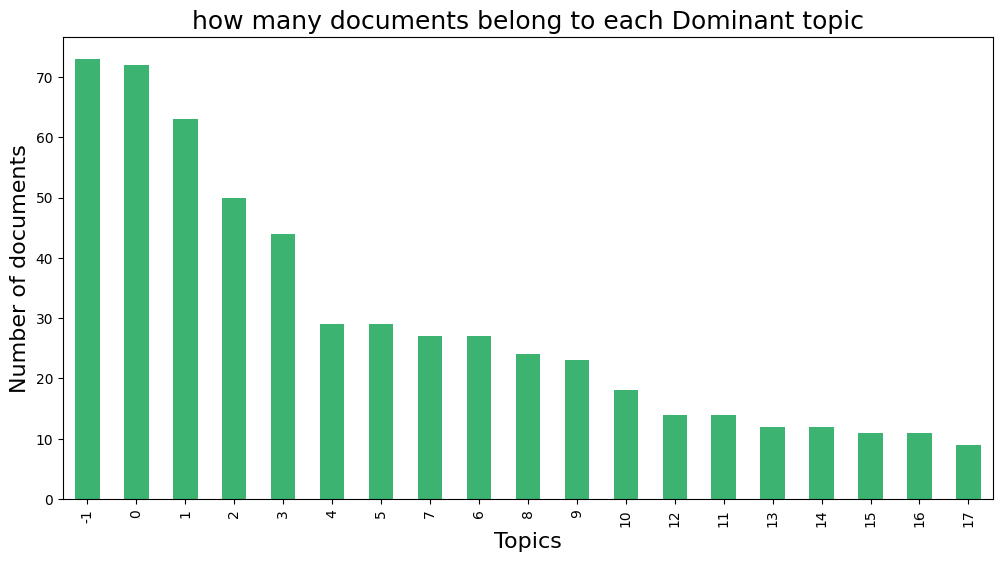

In [ ]:
topic_counts = bertopic["topic"].value_counts()
topic_counts.plot(kind = "bar", color = "mediumseagreen", figsize = (12,6))
plt.title("how many documents belong to each Dominant topic", size = 18)
plt.xlabel("Topics", size = 16)
plt.ylabel("Number of documents", size = 16)

In [ ]:
print('No. of outliers:', len(bertopic[bertopic['topic'] == -1]))
print('% of outliers:', len(bertopic[bertopic['topic'] == -1])/len(bertopic))

No. of outliers: 73
% of outliers: 0.1298932384341637


#### Add main topic

In [ ]:
docs_bert = bertopic['for_topic_model'].to_list()

In [ ]:
bert_viz(cust_model, docs_bert, viz='hierarchical')

100%|██████████| 17/17 [00:12<00:00,  1.40it/s]


In [ ]:
# Q1
main_topics = {
                'A': [4, 9, 11, 14],
                'B': [6, 8, 12, 16],
                'C': [1, 2, 3, 7, 10, 15, 17],
                'D': [0, 5, 13]
                }


def main_topic(x, main_topics_dic):

    for k, v in main_topics_dic.items():
        if x in v:
            return k


In [ ]:
bertopic

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model,cleaned,cleaned_joined,length,topic,topic_probability,main_topic,Sub-topic
0,Leadership,"Towards autonomous team, leadership should tru...","towards autonomous team, leadership should tru...","['autonomous', 'team', 'leadership', 'trust', ...",autonomous team leadership trust nurture self ...,22,2,0.313413,C,2_company_teams_leadership_work_processes_leve...
1,Leadership,I've been here for a year. There are things do...,i've been here for a year. there are things do...,"['year', 'thing', 'lot', 'thing', 'inefficient...",year thing lot thing inefficient choose leader...,45,2,1.000000,C,2_company_teams_leadership_work_processes_leve...
2,Leadership,Leaders should be role models. They should be ...,leaders should be role models. they should be ...,"['leader', 'role', 'model', 'appoint', 'base',...",leader role model appoint base competence know...,35,2,1.000000,C,2_company_teams_leadership_work_processes_leve...
3,Leadership,I observe some leaders are reactive in making ...,i observe some leaders are reactive in making ...,"['leader', 'reactive', 'make', 'decision', 'as...",leader reactive make decision ask context,14,2,1.000000,C,2_company_teams_leadership_work_processes_leve...
4,Leadership,Leaders lead by example,leaders lead by example.,"['leader', 'lead', 'example']",leader lead example,4,2,1.000000,C,2_company_teams_leadership_work_processes_leve...
...,...,...,...,...,...,...,...,...,...,...
557,Goals & Objectives,If we're able to manage everyone's workloads f...,if we're able to manage everyone's workloads f...,"['able', 'manage', 'workload', 'few', 'priorit...",able manage workload few priority lead burnout...,28,5,1.000000,B,5_balance_work_stress_workloads_headcount_week...
558,"Stress, Balance & Workload",seems like common reason why employees are res...,seems like common reason why employees are res...,"['common', 'reason', 'employee', 'resign', 'ov...",common reason employee resign overload work lo...,26,5,0.056703,B,5_balance_work_stress_workloads_headcount_week...
559,"Stress, Balance & Workload",some teams are loaded with too much work.,some teams are loaded with too much work.,"['team', 'load', 'work']",team load work,8,5,0.061927,B,5_balance_work_stress_workloads_headcount_week...
560,"Stress, Balance & Workload","Company is fast paced, leading to overworked e...","company is fast paced, leading to overworked e...","['company', 'fast', 'pace', 'lead', 'overworke...",company fast pace lead overworked employee ord...,14,5,0.054541,B,5_balance_work_stress_workloads_headcount_week...


In [ ]:
bertopic['main_topic'] = bertopic['topic'].apply(lambda x: main_topic(x, main_topics))

In [ ]:
for i in main_topics.keys():
    print('Main Topic: ' + str(i))
    print(bertopic[bertopic['main_topic'] == i]['topic'].value_counts(), '\n')

Main Topic: A
4     29
9     23
11    14
14    12
Name: topic, dtype: int64 

Main Topic: B
6     27
8     24
12    14
16    11
Name: topic, dtype: int64 

Main Topic: C
1     63
2     50
3     44
7     27
10    18
15    11
17     9
Name: topic, dtype: int64 

Main Topic: D
0     72
5     29
13    12
Name: topic, dtype: int64 



#### Add top word representation

In [ ]:
bertopic['Sub-topic'] = bertopic['topic'].apply(lambda x: str(x)+'_'+'_'.join([word for word, _ in cust_model.get_topic(x)]))

In [ ]:
bertopic.head()

,Category,What is the one improvement that would make the biggest difference in how we serve our customers?,for_topic_model,cleaned,cleaned_joined,length,topic,topic_probability,main_topic,Sub-topic
0,Leadership,"Towards autonomous team, leadership should tru...","towards autonomous team, leadership should tru...","['autonomous', 'team', 'leadership', 'trust', ...",autonomous team leadership trust nurture self ...,22,2,0.313413,C,2_company_teams_leadership_work_processes_leve...
1,Leadership,I've been here for a year. There are things do...,i've been here for a year. there are things do...,"['year', 'thing', 'lot', 'thing', 'inefficient...",year thing lot thing inefficient choose leader...,45,2,1.000000,C,2_company_teams_leadership_work_processes_leve...
2,Leadership,Leaders should be role models. They should be ...,leaders should be role models. they should be ...,"['leader', 'role', 'model', 'appoint', 'base',...",leader role model appoint base competence know...,35,2,1.000000,C,2_company_teams_leadership_work_processes_leve...
3,Leadership,I observe some leaders are reactive in making ...,i observe some leaders are reactive in making ...,"['leader', 'reactive', 'make', 'decision', 'as...",leader reactive make decision ask context,14,2,1.000000,C,2_company_teams_leadership_work_processes_leve...
4,Leadership,Leaders lead by example,leaders lead by example.,"['leader', 'lead', 'example']",leader lead example,4,2,1.000000,C,2_company_teams_leadership_work_processes_leve...


##### Export df to CSV

This should be the new arranged bertopic based on the supervised model.

In [ ]:
bertopic.to_csv(r'/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topics/bertopic_'+q+'.csv', index=False)

# Add to Topic_Names

In [ ]:
def top_names(df):
    main_topic = []
    topic = []
    for i, j in bertopic[bertopic['topic'] != -1].groupby(['main_topic', 'topic']).describe().index:
        main_topic.append(i), topic.append(j)

    top_names_dic = {
        'main_topic': main_topic,
        'topic': topic,
    }
    df = pd.DataFrame(top_names_dic)

    df.rename(columns={'main_topic': 'Topic',
                            'topic': 'Sub-sub-topic'}, inplace=True)

    df['Sub-topic'] = df['Sub-sub-topic'].apply(lambda x: str(x)+'_'+'_'.join([word for word, _ in cust_model.get_topic(x)]))

    return df

In [ ]:
top_names = top_names(bertopic)

In [ ]:
top_names

,Topic,Sub-sub-topic,Sub-topic
0,A,4,4_service_customers_feedback_urgent concerns_s...
1,A,9,9_services_customer_development_discounts_busi...
2,A,11,11_financial inclusion_business_inclusion_top ...
3,A,14,14_loyal customers_concerns_cxm initiatives_be...
4,B,6,6_deployment_approvals_tech_documentation_acce...
5,B,8,8_procedures_changes_efficient_internal proces...
6,B,12,12_streamlined_internal processes_inefficienci...
7,B,16,16_data_tables_reports_automation_digital comp...
8,C,1,1_teams_collaboration_communication_projects_b...
9,C,2,2_company_teams_leadership_work_processes_leve...


In [ ]:
top_names['Question'] = q+': '+bertopic.columns[3]
top_names['q_name'] = bertopic.columns[3]
top_names['q_number'] = q

In [ ]:
top_names['topic_name'] = np.nan
top_names['sub-topic_name'] = np.nan

In [ ]:
top_names.head(1)

,Topic,Sub-sub-topic,Sub-topic,Question,q_name,q_number,topic_name,sub-topic_name
0,A,4,4_service_customers_feedback_urgent concerns_s...,Q1: cleaned,cleaned,Q1,NaN,NaN


## Export df to CSV

In [ ]:
top_names.to_csv(r'/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topics/topic_names_'+q+'.csv', index=False)

# Final Summarizer

- We need to summarize again using LLM since the docs have been changed in clusters
- Also include a topic Description overall for main_topic

https://docs.cohere.com/docs/models

In [ ]:
import time

def inf_s(df, model):
    # topic = []
    summary = []
    topic_words = [[word for word, prob in model.get_topic(topic)] for topic in set(model.topics_) if topic != -1]

    for i in [17]:
        KEYWORDS = topic_words[i]
        DOCUMENTS = df[df['topic'] == i]['for_topic_model'].to_list()

        print('Topic:', i)

        if len(DOCUMENTS) > 10:

            infer_summarize = f'''
            Summarize what is discussed in the documents: {DOCUMENTS} and the following keywords: {KEYWORDS} in 3 sentences and do not repeat the documents.

            '''

            while True:
                try:
                    response = co.generate(
                    prompt=infer_summarize,
                    temperature = 2,
                    max_tokens = 150,
                    num_generations = 1
                    # frequency_penalty = 0.5,
                    # presence_penalty = 0.5
                    )
                    summary.append(str(response[0]))
                    break
                except cohere.CohereAPIError:
                    print("Reached API limit. Waiting for 60 seconds...")
                    time.sleep(60)

        else:

            infer_summarize = f'''
            Summarize what is discussed in the documents: {' '.join(DOCUMENTS)} and the following keywords: {' '.join(KEYWORDS)} in 3 sentences and do not repeat the documents.

            '''

            while True:
                try:
                    response = co.generate(
                    prompt=infer_summarize,
                    temperature = 2,
                    max_tokens = 150,
                    num_generations = 1
                    # frequency_penalty = 0.5,
                    # presence_penalty = 0.5
                    )
                    summary.append(str(response[0]))
                    break
                except cohere.CohereAPIError:
                    print("Reached API limit. Waiting for 60 seconds...")
                    time.sleep(60)



        print('\n')

    return summary

In [ ]:
summary = inf_s(bertopic, cust_model)

Topic: 17


Your text contains a trailing whitespace, which has been trimmed to ensure high quality generations.


In [ ]:
sum_data = pd.DataFrame({'topic': list(set(cust_model.topics_))[:-1],
              'inferred_summary': summary,
              'sub-topic_name': sub_topic_name})

In [ ]:
sum_data

,topic,inferred_topic,inferred_summary,sub-topic_name
0,0,Employee Compensation and Benefits,The feedback from employees contains a mix of ...,Improve Compensation and Benefits
1,1,collaboration,The collaboration between different teams and ...,Collaboration
2,2,from the ground up,"towards autonomous team, leadership should tru...",Leadership
3,3,Promoting employees based on tenure,The people that are involved with gcash have s...,Improve Mobile App
4,4,faster turn around time and more efficiency,The list of documents contains issues and solu...,Operating Efficiency
5,5,balancing workload and work-life,The employees in this company are continuously...,Importance of Work-life Balance
6,6,"Training, learning and development",The documents contain a wide range of suggesti...,Learning & Development
7,7,Call center/hotline services,The documents mention several recommendations ...,Improve Customer Service
8,8,Serve your customers,The information above is a collection of quote...,Serve and take care of Customers
9,9,Topic: how to improve our company,The documents discuss issues that may arise wh...,Role Management


## Export df to CSV

In [ ]:
sum_data.to_csv(r'/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topic_summary/topic_sum_'+q+'.csv', index=False)

# Infer TOPIC Description

In [ ]:
import time

def inf_ts_desc(df, model):
    main_topic_summary = []

    for i in list(df['main_topic'].unique())[:-1]:
        DOCUMENTS = bertopic[bertopic['main_topic'] == i]['for_topic_model'].to_list()

        # infer_description = f'''I have a topic that is described by the following documents: {DOCUMENTS}
        # Give me a one sentence brief description of the whole context of documents present. Make it very short.
        # '''

        infer_description = f'''Give me a brief short 1 sentence description of the following documents: {DOCUMENTS}
        '''

        print('Topic:', i)

        while True:
            try:
                response = co.generate(
                model='summarize-xlarge',
                prompt=infer_description,
                temperature = 1,
                max_tokens = 500,
                num_generations = 1,
                truncate = 'END'
                )
                main_topic_summary.append(str(response[0]))
                break
            except cohere.CohereAPIError:
                print("Reached API limit. Waiting for 60 seconds...")
                time.sleep(60)

        print('\n')

    return main_topic_summary

In [ ]:
main_topic_summary_1 = inf_ts_desc(bertopic, cust_model)

Topic: C


Your text contains a trailing whitespace, which has been trimmed to ensure high quality generations.




Topic: B


Your text contains a trailing whitespace, which has been trimmed to ensure high quality generations.




Topic: D


Your text contains a trailing whitespace, which has been trimmed to ensure high quality generations.




Topic: A


Your text contains a trailing whitespace, which has been trimmed to ensure high quality generations.


In [ ]:
sum_data_desc = pd.DataFrame({'main_topic': list(bertopic['main_topic'].unique())[:-1],
              'inferred_desc': mt_sum})

In [ ]:
sum_data_desc

,main_topic,inferred_desc
0,C,optimization of products and services to ensur...
1,B,More work-life balance and less work stress fo...
2,D,This is a group of documents describing variou...
3,A,Customer Service and Satisfaction is a concern...


## Export df to CSV

In [ ]:
sum_data_desc.to_csv(r'/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topic_summary/topic_sum_desc_'+q+'.csv', index=False)

# LOAD UPDATED DATAFRAMES

In [ ]:
bertopic = pd.read_csv('/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topics/bertopic_'+q+'.csv')
sum_data = pd.read_csv('/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topic_summary/topic_sum_'+q+'.csv')
sum_data_desc = pd.read_csv('/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topic_summary/topic_sum_desc_'+q+'.csv')

# Save merged df with LLM Results

In [ ]:
merged_df = bertopic.merge(sum_data, how='outer', on='topic')

In [ ]:
merged_df_final = merged_df.merge(sum_data_desc, how='outer', on='main_topic')

In [ ]:
merged_df_final['sub-topic_name'] = merged_df_final['sub-topic_name'].fillna('Outlier')

In [ ]:
merged_df_final['sub-topic_name'].value_counts()

Outlier                                      73
Improve Compensation and Benefits            72
Collaboration                                63
Leadership                                   50
Improve Mobile App                           44
Importance of Work-life Balance              29
Improve Customer Service                     29
Learning & Development                       27
Operating Efficiency                         27
Improve Processes                            24
Improve Products & Services for Customers    23
Role Management                              18
Streamline Internal Processes                14
Serve and take care of Customers             14
Work From Home                               12
Increase Customer Engagement                 12
Product Issues Internally                    11
Working Efficiency                           11
Information Cascade                           9
Name: sub-topic_name, dtype: int64

In [ ]:
merged_df_final.to_csv(r'/content/drive/Shareddrives/HR x R&D Collaboration/Topic Modeling/GPulse Free-Text Responses/data/topics/bertopic_llm_'+q+'.csv', index=False)